# Chart Pattern with CNN

dataset saved at [dropbox](https://www.dropbox.com/home/wds23s4_bwl_chartformation_dataset)

draft text at [share point](https://dhbwloerrachde-my.sharepoint.com/:w:/g/personal/salvadoc_dhbw-loerrach_de/EVaAuPh0o2NCkm2lsGT4WHMBiBt3HxajKn6lm9RDp4gK2g?e=Aq9khT)

# Library

In [294]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import itertools
import mplfinance as mpf
import numpy as np
import pandas as pd

import zipfile
import py7zr
import os
import json
import pickle

import yfinance as yf


## Machine Learning imports
# for data processing:

import tensorflow as tf
from sklearn.model_selection import train_test_split # pip install scikit-learn

# for CNN 1D model:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from scipy.interpolate import interp1d
# for model evaluation:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


# for CNN private functions: (update cnn_group_trainer as library without restart the kernel if .py is changed!)
import importlib
import utils as myutils
importlib.reload(myutils)



<module 'utils' from 'd:\\dhbw_s3\\wds23s4_fibu_chartformation\\utils.py'>

# DATASET Hermaeus

data from [Hermeaus](https://github.com/Hermaeus1618/PatternRecognition)

... need to download by hand and unzip it! 

The usded file `"aaatemp/DATASET.zfs"` has been unziped already!

## group classification (map!)

data from [Hermeaus](https://github.com/Hermaeus1618/PatternRecognition), but classification based on [Bulkowski](https://thepatternsite.com/) + its Book 

useful later to deal with the original data frame (raw data).

In [22]:
# IMPORTANT: *Potential has no group! this classification is done by .fillna("Other_group") below

pattern_group_map = {
    # Head and Shoulders
    "HeadAndShoulder": "Group_HeadShoulder",
    "ReverseHeadAndShoulder": "Group_HeadShoulder",

    # Double Tops and Bottoms
    "DoubleTop": "Group_Double",
    "DoubleBottom": "Group_Double",
    "DoubleTopInitiate": "Group_Double",
    "DoubleBottomInitiate": "Group_Double",

    # Triangles
    "AscendingTriangle": "Group_Triangle",
    "DescendingTriangle": "Group_Triangle",
    "SymmetricTriangle": "Group_Triangle",
    "AscendingTriangleBD": "Group_Triangle",
    "DescendingTriangleBD": "Group_Triangle",
    "SymmetricTriangleBO": "Group_Triangle",
    "AscendingTriangleBO": "Group_Triangle",

    # Rectangle/Channels
    "RectangleChannel": "Group_Rectangle",
    "RectangleChannelBD": "Group_Rectangle",
    "RectangleChannelBO": "Group_Rectangle",

    # Flags and Pennants
    "BullishFlag": "Group_Flag",
    "BearishFlag": "Group_Flag",
    "BullishPennant": "Group_Flag",
    "BearishPennant": "Group_Flag",

    # Cup Patterns
    "CupAndHandle": "Group_Cup",
    "InverseCupAndHandle": "Group_Cup",

    # Triple Patterns
    "TripleTop": "Group_Triple",
    "TripleBottom": "Group_Triple",

    # Rounded
    "RoundingTop": "Group_Rounded",
    "RoundingBottom": "Group_Rounded",

    # Channel Slopes
    "AscendingChannelBD": "Group_Channel",
    "AscendingChannelBO": "Group_Channel",
    "DescendingChannel": "Group_Channel",
    "DescendingChannelBD": "Group_Channel",
}


In [ ]:
pattern_group_map

{'Group_Channel',
 'Group_Cup',
 'Group_Double',
 'Group_Flag',
 'Group_HeadShoulder',
 'Group_Rectangle',
 'Group_Rounded',
 'Group_Triangle',
 'Group_Triple'}

## DATA

#### data frame complete (raw)

In [23]:
dataset01_path_zip = "aaatemp/DATASET.zfs"
dataset01_df = myutils.dataset_extract_from_zip(dataset01_path_zip)

start_list, end_list, time_range_list = [], [], []
for index, row in dataset01_df.iterrows():
    start, end, time_range = myutils.calculate_time_range_per_row(row)
    start_list.append(start)
    end_list.append(end)
    time_range_list.append(time_range)

dataset01_df["PatternGroup"] = dataset01_df["Pattern"].map(pattern_group_map).fillna("Group_Other")

dataset01_df["StartDate"] = start_list # pd.to_datetime(dataset01_df["Start"], unit="s")
dataset01_df["EndDate"] = end_list #pd.to_datetime(dataset01_df["End"], unit="s")
dataset01_df["TimeRange"] = time_range_list # pd.to_datetime(dataset01_df["Start"], unit="s")
dataset01_df["Array_norm"] = dataset01_df["Array"].apply(lambda x: x/np.mean(x) if isinstance(x, np.ndarray) else x)
dataset01_df["ArrayLength"] = dataset01_df["Array"].apply(len)
dataset01_df["ArrayMedian"] = dataset01_df["Array"].apply(lambda x: np.median(x))

discrepancies = dataset01_df[dataset01_df["ArrayLength"] != dataset01_df["TimeRange"].apply(len)]
if not discrepancies.empty:
    print("Divergences found between ArrayLength and TimeRange:")
    print(discrepancies[["Company", "Pattern", "ArrayLength", "TimeRange"]])

print(dataset01_df.shape)
print(dataset01_df.head())

Divergences found between ArrayLength and TimeRange:
          Company            Pattern  ArrayLength  \
0       AXISCADES  AscendingTriangle           82   
1        BOSCHLTD  AscendingTriangle           18   
2       CELLPOINT  AscendingTriangle            9   
3          CHAVDA  AscendingTriangle          114   
4            DHTL  AscendingTriangle           17   
...           ...                ...          ...   
59027        LTIM  DoubleTopInitiate           56   
59028   MAXHEALTH  DoubleTopInitiate           15   
59029         ACC        RoundingTop           14   
59030  ADANIENSOL        RoundingTop           21   
59031  APOLLOHOSP        RoundingTop           15   

                                               TimeRange  
0      DatetimeIndex(['2024-05-02', '2024-05-03', '20...  
1      DatetimeIndex(['2024-08-06', '2024-08-07', '20...  
2      DatetimeIndex(['2024-08-20', '2024-08-21', '20...  
3      DatetimeIndex(['2024-03-13', '2024-03-14', '20...  
4      Datetime

In [308]:
#print(dataset01_df.groupby(["Pattern","PatternGroup",]).size().sort_values(ascending=False)) 
df4print_all = (
    dataset01_df.groupby(["PatternGroup", "Pattern"])
    .size()
    .reset_index(name='Count')
    .sort_values(by=["PatternGroup", "Pattern",'Count'], ascending=False)
)
print(df4print_all)
                                       
df4print_all.to_csv("aaatemp/PatternGroup_Counts.csv", index=False)

          PatternGroup                          Pattern  Count
36        Group_Triple                        TripleTop    182
35        Group_Triple                     TripleBottom    160
34      Group_Triangle              SymmetricTriangleBO   1631
33      Group_Triangle                SymmetricTriangle   2161
32      Group_Triangle             DescendingTriangleBD   1267
31      Group_Triangle               DescendingTriangle   2439
30      Group_Triangle              AscendingTriangleBO   1101
29      Group_Triangle              AscendingTriangleBD   1538
28      Group_Triangle                AscendingTriangle   2500
27       Group_Rounded                      RoundingTop   2889
26       Group_Rounded                   RoundingBottom   2862
25     Group_Rectangle               RectangleChannelBO   1639
24     Group_Rectangle               RectangleChannelBD   1636
23     Group_Rectangle                 RectangleChannel   3157
22         Group_Other               TripleTopPotential

In [302]:
df4print_all

,,0
Pattern,PatternGroup,
RectangleChannel,Group_Rectangle,3157
DescendingChannel,Group_Channel,2979
RoundingTop,Group_Rounded,2889
RoundingBottom,Group_Rounded,2862
AscendingTriangle,Group_Triangle,2500
DoubleTopPotential,Group_Other,2500
DoubleBottomInitiate,Group_Double,2441
DescendingTriangle,Group_Triangle,2439
DoubleTopInitiate,Group_Double,2431


In [25]:
print(dataset01_df.groupby(["Frequency"]).size().sort_values(ascending=False)) # ['DAILY' 'WEEKLY' 'MONTHLY' 'MIN5' 'MIN15' 'MIN30' 'HOUR1']

Frequency
HOUR1      13419
MIN30      12884
MIN15      11348
MIN5        9370
DAILY       7611
WEEKLY      3151
MONTHLY     1249
dtype: int64


<Axes: >

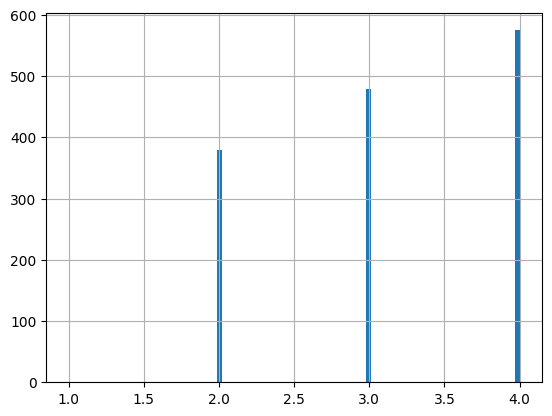

In [26]:
dataset01_df.loc[dataset01_df["ArrayLength"] < 5, "ArrayLength"].hist(bins=100)

  

In [27]:
# dataset01_df["IsCandlePossible"] = dataset01_df.apply(is_candlestick_viable, axis=1)


#### Header and Shoulder (HAS)

In [28]:
#dataset01_df_has_charts = ["HeadAndShoulder","ReverseHeadAndShoulder","RectangleChannel","DescendingChannel"]
dataset01_df_has_charts = ["HeadAndShoulder","ReverseHeadAndShoulder","RectangleChannel","DescendingChannel","RoundingTop","RoundingBottom","AscendingTriangle","DescendingTriangle","SymmetricTriangle","DoubleBottom","DoubleTop","BearishFlag","InverseCupAndHandle"]



dataset01_df_has = dataset01_df.copy()
dataset01_df_has = dataset01_df_has[dataset01_df_has["Pattern"].isin(dataset01_df_has_charts)]#.str.contains("HeadAndShoulder")]
dataset01_df_has = dataset01_df_has[dataset01_df_has["ArrayLength"] > 6] # HAS need at leas 7 points
print(dataset01_df_has.shape)
print(dataset01_df_has.groupby(["Pattern"]).size().sort_values(ascending=False))

(27109, 13)
Pattern
RectangleChannel          3150
DescendingChannel         2910
RoundingTop               2881
RoundingBottom            2847
AscendingTriangle         2441
DescendingTriangle        2391
SymmetricTriangle         2035
DoubleBottom              1797
DoubleTop                 1796
HeadAndShoulder           1590
ReverseHeadAndShoulder    1197
InverseCupAndHandle       1066
BearishFlag               1008
dtype: int64


In [29]:
print(dataset01_df_has.groupby("Pattern")["ArrayLength"].describe())

                         count        mean        std   min    25%   50%  \
Pattern                                                                    
AscendingTriangle       2441.0   60.177796  48.999585   7.0  26.00  43.0   
BearishFlag             1008.0   39.038690  39.837200   7.0  17.00  28.0   
DescendingChannel       2910.0   50.505155  42.510846   7.0  22.00  35.0   
DescendingTriangle      2391.0   61.311585  85.251488   7.0  26.00  41.0   
DoubleBottom            1797.0   33.877017  24.920160   7.0  15.00  25.0   
DoubleTop               1796.0   33.585746  25.596241   7.0  14.75  25.0   
HeadAndShoulder         1590.0   43.035849  60.035048   7.0  20.00  29.0   
InverseCupAndHandle     1066.0  102.105066  56.073729  11.0  56.00  89.0   
RectangleChannel        3150.0   61.492381  59.464690   7.0  25.00  41.5   
ReverseHeadAndShoulder  1197.0   41.639098  29.769910   7.0  21.00  29.0   
RoundingBottom          2847.0   60.536354  50.984344   7.0  25.00  45.0   
RoundingTop 

In [30]:
dataset01_df_has_balanced = dataset01_df_has.copy()
dataset01_df_has_balanced = myutils.dataset_balanced_filtered(dataset01_df_has_balanced, max_len=64)
print(dataset01_df_has_balanced.groupby("Pattern")["ArrayLength"].describe())

                        count       mean        std   min   25%   50%   75%  \
Pattern                                                                       
AscendingTriangle       339.0  49.032448   4.638609  41.0  44.0  50.0  52.0   
BearishFlag             339.0  41.421829   8.895960  28.0  34.0  40.0  50.0   
DescendingChannel       339.0  49.289086   4.027153  42.0  45.0  50.0  52.0   
DescendingTriangle      339.0  48.684366   4.551229  41.0  44.0  50.0  52.0   
DoubleBottom            339.0  41.253687   9.191291  28.0  33.0  41.0  50.0   
DoubleTop               339.0  41.622419   9.260476  29.0  33.0  40.0  50.0   
HeadAndShoulder         339.0  44.884956   7.417498  34.0  39.0  43.0  51.0   
InverseCupAndHandle     339.0  45.616519  11.762963  11.0  36.0  49.0  54.0   
RectangleChannel        339.0  47.988201   5.282536  40.0  43.0  49.0  51.0   
ReverseHeadAndShoulder  339.0  40.386431   9.283245  28.0  31.0  40.0  50.0   
RoundingBottom          339.0  49.581121   3.887668 

### ARRAY TO FILE (.png, .npy)

plot_and_save_by_pattern_from_zipfile()

plot_and_save_by_pattern_from_df()

Example:
```python
# Plots für die ersten 10 Dateien erstellen
dataset_path_dropbox = r"C:\Users\carlo\Dropbox\wds23s4_bwl_chartformation_dataset"
plot_and_save_by_pattern_from_zipfile(ZIP_PATH, "HeadAndShoulder", max_plots=10, dropbox_folder=dataset_path_dropbox)

# Call the function with the updated DataFrame
plot_and_save_by_pattern_from_df(dataset01_df, "TripleTop", max_plots=10, dropbox_folder=dataset_path_dropbox)
```


#### HAS

In [38]:
dataset_path_dropbox = r"C:\Users\carlo\Dropbox\wds23s4_bwl_chartformation_dataset"
dataset_path_dropbox_dataset = os.path.join(dataset_path_dropbox, "dataset")
dataset_path_dropbox_dataset_npy = os.path.join(dataset_path_dropbox, "dataset_npy")

has_dataset_run_again = True # just to control the execution and avoid multiple runs.  

if has_dataset_run_again:

    os.makedirs(dataset_path_dropbox_dataset, exist_ok=True)

    for pattern in dataset01_df_has_balanced["Pattern"].unique():
        myutils.plot_and_save_by_pattern_from_df(dataset01_df_has, pattern, max_plots=10, dropbox_folder=dataset_path_dropbox_dataset)
        myutils.save_array_as_npy_by_pattern(dataset01_df_has_balanced, pattern, output_folder=dataset_path_dropbox_dataset_npy, normalize_method="mean")
        print(f"Pattern {pattern} processed and saved.")
        print("N files in folder:", len(os.listdir(os.path.join(dataset_path_dropbox_dataset_npy, pattern))))



Pattern InverseCupAndHandle processed and saved.
N files in folder: 339
Pattern AscendingTriangle processed and saved.
N files in folder: 339
Pattern BearishFlag processed and saved.
N files in folder: 339
Pattern DescendingChannel processed and saved.
N files in folder: 339
Pattern DescendingTriangle processed and saved.
N files in folder: 339
Pattern DoubleBottom processed and saved.
N files in folder: 339
Pattern DoubleTop processed and saved.
N files in folder: 339
Pattern HeadAndShoulder processed and saved.
N files in folder: 339
Pattern RectangleChannel processed and saved.
N files in folder: 339
Pattern ReverseHeadAndShoulder processed and saved.
N files in folder: 339
Pattern RoundingBottom processed and saved.
N files in folder: 339
Pattern RoundingTop processed and saved.
N files in folder: 339
Pattern SymmetricTriangle processed and saved.
N files in folder: 339


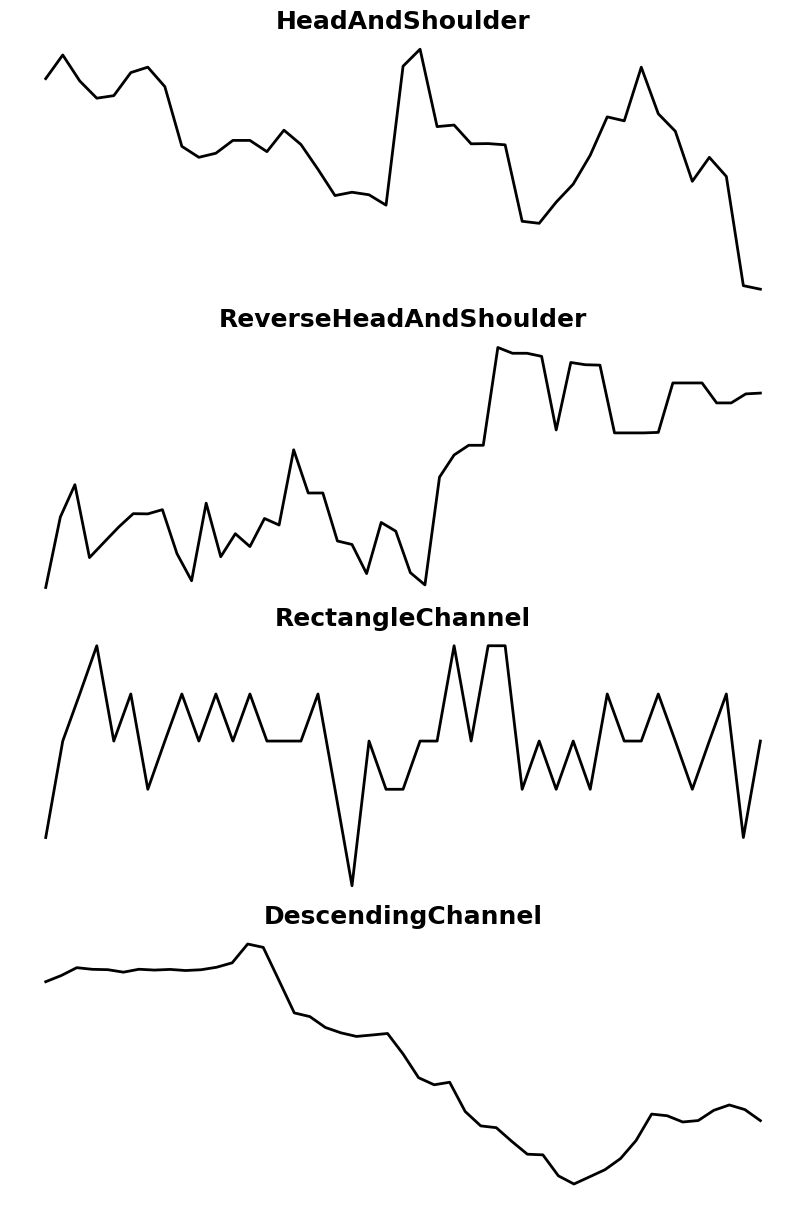

In [39]:
dataset01_df_has_test_plot_file_candidates_i = [152,27,222,100]

fig, axs = plt.subplots(len(dataset01_df_has_test_plot_file_candidates_i), 1, figsize=(8, 3*len(dataset01_df_has_test_plot_file_candidates_i)))

for i,f in enumerate(dataset01_df_has_test_plot_file_candidates_i):
    dataset01_df_has_test_plot_file_candidates_folder = os.path.join(dataset_path_dropbox_dataset_npy,dataset01_df_has_charts[i])
    dataset01_df_has_test_plot_file_candidates = os.listdir(dataset01_df_has_test_plot_file_candidates_folder)[f]
    dataset01_df_has_test_plot_file_candidates = os.path.join(dataset01_df_has_test_plot_file_candidates_folder, dataset01_df_has_test_plot_file_candidates)
    #print(dataset01_df_has_test_plot_file_candidates)

    dataset01_df_has_test_plot_file_candidates4plot = np.load(dataset01_df_has_test_plot_file_candidates)

    axs[i].plot(dataset01_df_has_test_plot_file_candidates4plot, color="black", linewidth=2)
    axs[i].set_title(dataset01_df_has_charts[i], fontsize=18, fontweight='bold')
    axs[i].axis("off")
plt.tight_layout(pad=0.5)

# CNN 1D

* CNN 1D --> use data .npy!!!... need padding to set the size of array (Cons). Pros: quick, less memmory, use temporal series direct.

* CNN 2D --> use data .png!!!... don´t need padding (Pros!), because the plots (figure) are built with standart size and resolution.

## HAS
### data (load .npy)

In [41]:
X_raw, y_raw, label_map = myutils.load_npy_dataset(dataset_path_dropbox_dataset_npy)
print(label_map)
print(len(X_raw), len(y_raw))


{0: 'AscendingTriangle', 1: 'BearishFlag', 2: 'DescendingChannel', 3: 'DescendingTriangle', 4: 'DoubleBottom', 5: 'DoubleTop', 6: 'HeadAndShoulder', 7: 'InverseCupAndHandle', 8: 'RectangleChannel', 9: 'ReverseHeadAndShoulder', 10: 'RoundingBottom', 11: 'RoundingTop', 12: 'SymmetricTriangle'}
4407 4407


4407


(array([   2.,    6.,   16.,  344.,  327.,  614.,  900., 1546.,  570.,
          82.]),
 array([11. , 16.3, 21.6, 26.9, 32.2, 37.5, 42.8, 48.1, 53.4, 58.7, 64. ]),
 <BarContainer object of 10 artists>)

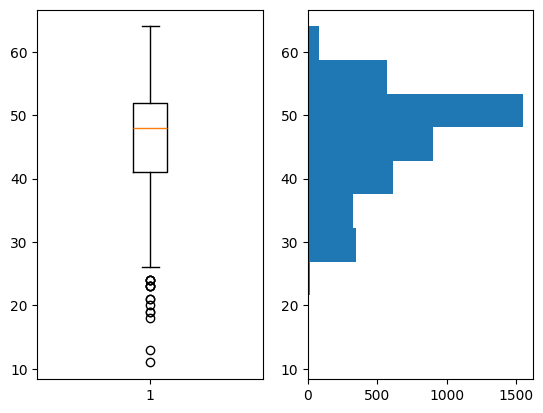

In [42]:
X_raw_len_list = [len(x) for x in X_raw]
print(len(X_raw_len_list))

fig, ax = plt.subplots(1,2)
ax[0].boxplot(X_raw_len_list)
ax[1].hist(X_raw_len_list,orientation ='horizontal')

### Padding + Reshape + split

In [ ]:
cnn1d_target_len = 64  # USED MANY TIMES LATER!!! value after analyse! multiple of 8, less padding needed, more efficient for CNN 1D models

X_padded = myutils.pad_sequences(X_raw, target_len=cnn1d_target_len, method='zero')  
X_padded = X_padded.reshape(-1, cnn1d_target_len, 1)
y = np.array(y_raw)

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)




### Model Build: Sequential + Compile

In [45]:
# input shape and number of classes
input_shape = (cnn1d_target_len, 1)  # 1 means single channel (univariate time series x price). If it was OLHC data, it would be (cnn1d_target_len, 4) for Open, Low, High, Close.
num_classes = len(np.unique(y_train))  # number of unique labels

print(input_shape)
print(num_classes)

(64, 1)
13


In [46]:

model = Sequential([
    Input(shape=input_shape),

    Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Multiclass output
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # labels are integers, not one-hot
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,597 (545.30 KB)

 Trainable params: 139,405 (544.55 KB)

 Non-trainable params: 192 (768.00 B)

### Training (model.fit())

In [47]:
# early breacking setting to avoid overfitting
# This callback will stop training when a monitored metric has stopped improving.
# ... no improvements after 5 epochs.

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [48]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32, # X_train / batch_siez ~ 39!.. for this reason 39/39 batch size
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1089 - loss: 2.7281 - val_accuracy: 0.1565 - val_loss: 2.5271
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1389 - loss: 2.4202 - val_accuracy: 0.1361 - val_loss: 2.4617
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1434 - loss: 2.3757 - val_accuracy: 0.1383 - val_loss: 2.4025
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1419 - loss: 2.3643 - val_accuracy: 0.1837 - val_loss: 2.3443
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1389 - loss: 2.3470 - val_accuracy: 0.1383 - val_loss: 2.3495
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1362 - loss: 2.3347 - val_accuracy: 0.1587 - val_loss: 2.3118
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1388 - loss: 2.3300 - val_accuracy: 0.1587 - val_loss: 2.2907
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1402 - loss: 2.3126 - val_accuracy: 0.

#### save model

In [49]:
models_path4save = "aaatemp/models"
model_cnn1d_v1_file = os.path.join(models_path4save, "chartformation_cnn1d_v1.keras") # better than .h5!

os.makedirs(models_path4save, exist_ok=True)

model.save(model_cnn1d_v1_file) 


### Model evaluation

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


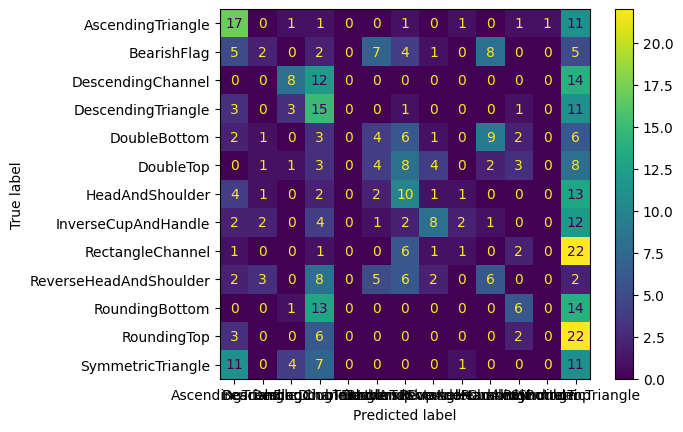

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred_test = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)
model_confmatrix = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, display_labels=label_map.values())


model_confmatrix_df = pd.DataFrame(model_confmatrix, index=list(label_map.values()), columns=list(label_map.values()))

model_confmatrix_df.to_csv("aaatemp/models/chartformation_cnn1d_v1_confusion_matrix.csv")

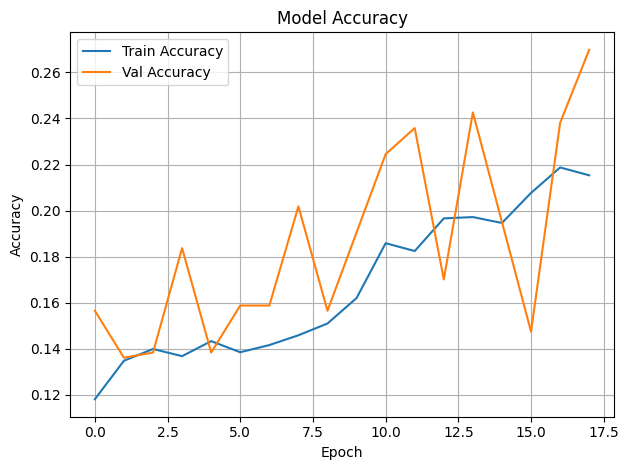

In [51]:
# training = validation with training data for learning
# validation = validation with validation (new = not seen!) data for generalization
# validation --> to check if the model is overfitting or not
# expect difference validation x training: good X bad learing, good x bad generalization...  overfitting if validation loss is higher than training loss, and validation accuracy is lower than training accuracy

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
model.evaluate(X_test, y_test) # X_test / 32 ~ 5 ... for this reason 5/5 batch size

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2103 - loss: 2.1509 


[2.193305492401123, 0.19954648613929749]

## GROUP (looping)


### groups ~ dataset

In [295]:
groups4cnn_list = dataset01_df["PatternGroup"].unique().tolist()
print(groups4cnn_list)

['Group_Triangle', 'Group_Channel', 'Group_Rectangle', 'Group_Other', 'Group_Double', 'Group_HeadShoulder', 'Group_Rounded', 'Group_Flag', 'Group_Cup', 'Group_Triple']


### MODEL: build + training (.fit!)

In [296]:
groups4cnn_folder = os.path.join("aaatemp", "groups4cnn")

for group in groups4cnn_list:
    if group != "Group_Other":
        myutils.train_model_per_group(dataset01_df, group_name=group, model_dir=groups4cnn_folder, method="zero")

Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1736 - loss: 72.5123 - val_accuracy: 0.1820 - val_loss: 20.7151
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1780 - loss: 20.3705 - val_accuracy: 0.1435 - val_loss: 27.7920
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1929 - loss: 11.2108 - val_accuracy: 0.1790 - val_loss: 24.3128
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1944 - loss: 10.0294 - val_accuracy: 0.2041 - val_loss: 7.6073
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1979 - loss: 4.5202 - val_accuracy: 0.1967 - val_loss: 9.7396
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2103 - loss: 3.9869 - val_accuracy: 0.1908 - val_loss: 7.3771
Epoch 7/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2022 - loss: 3.1720 - val_accuracy: 0.1908 - val_loss: 2.1059
Epoch 8/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1794 - loss: 2.1842 - val_accur

### MODEL: evaluation

groups4cnn_4evaluation: Group_Triangle
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


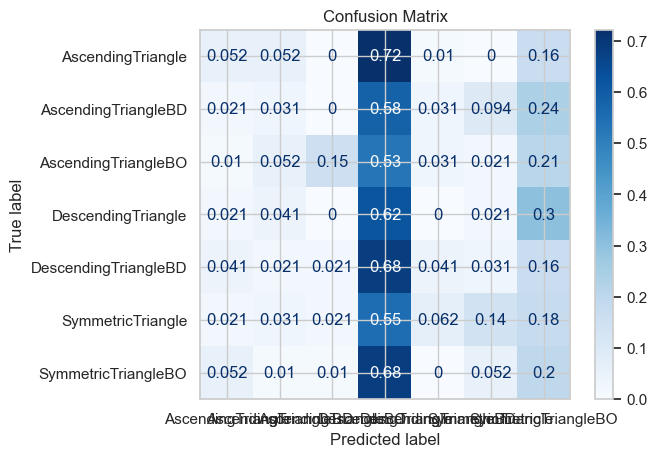

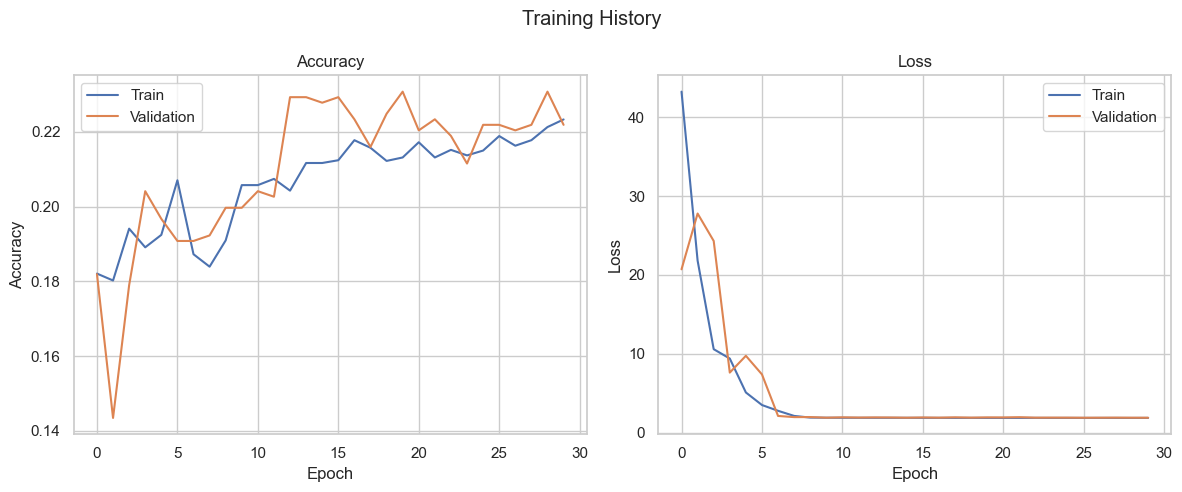

In [297]:
groups4cnn_4evaluation = groups4cnn_list[0]
print("groups4cnn_4evaluation:", groups4cnn_4evaluation)


model = load_model(f"aaatemp/groups4cnn/cnn_1d_{groups4cnn_4evaluation}.keras")
with open(f"aaatemp/groups4cnn/cnn_1d_{groups4cnn_4evaluation}_labelmap.json", "r") as f:
    label_map = json.load(f)
with open(f"aaatemp/groups4cnn/cnn_1d_{groups4cnn_4evaluation}_history.pkl", "rb") as f:
    history = pickle.load(f)

label_map = {int(k): v for k, v in label_map.items()}

# print("y_test unique:", np.unique(y_test))
# print("y_pred unique:", np.unique(y_pred))
# print("label_map:", label_map)
# print("len(label_map):", len(label_map))


# Filtre o DataFrame para o grupo correto
df_group = dataset01_df[dataset01_df["PatternGroup"] == groups4cnn_4evaluation]
df_group = myutils.dataset_balanced_filtered(df_group, max_len=64)
X, y, _ = myutils.prepare_group_arrays(df_group, target_len=64)

# Split igual ao treinamento
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

y_pred = model.predict(X_test).argmax(axis=1)
class_names = [label_map[i] for i in range(len(label_map))]
myutils.plot_confusion_matrix(y_test, y_pred, class_names=class_names)

myutils.plot_training_history(history)


In [300]:
groups4cnn_4evaluation_gvalid = [g for g in groups4cnn_list if g != "Group_Other"]
groups4cnn_4evaluation_accuracy = []
groups4cnn_4evaluation_lenght = []

for group in groups4cnn_4evaluation_gvalid:
    with open(f"aaatemp/groups4cnn/cnn_1d_{group}_labelmap.json", "r") as f:
        label_map = json.load(f)
        groups4cnn_4evaluation_lenght.append(len(label_map))
    with open(f"aaatemp/groups4cnn/cnn_1d_{group}_history.pkl", "rb") as f:
        history = pickle.load(f)
        groups4cnn_4evaluation_accuracy.append(max(history["accuracy"]))

groups4cnn_4evaluation_df = pd.DataFrame({"Group": groups4cnn_4evaluation_gvalid})
groups4cnn_4evaluation_df["npattern"] = groups4cnn_4evaluation_lenght
groups4cnn_4evaluation_df["Accuracy"] = groups4cnn_4evaluation_accuracy
print(groups4cnn_4evaluation_df)

groups4cnn_4evaluation_df.to_csv("aaatemp/cnn_1d_groups_evaluation.csv", index=False)

                Group  npattern  Accuracy
0      Group_Triangle         7  0.223331
1       Group_Channel         4  0.353311
2     Group_Rectangle         3  0.423404
3        Group_Double         4  0.322516
4  Group_HeadShoulder         2  0.654653
5       Group_Rounded         2  0.545524
6          Group_Flag         4  0.452168
7           Group_Cup         2  0.750865
8        Group_Triple         2  0.694175


In [ ]:
history

dict_values(['TripleBottom', 'TripleTop'])

(0.0, 0.8)

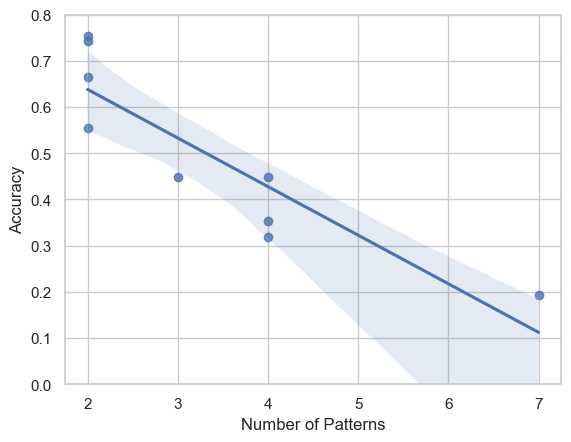

In [ ]:
import seaborn as sns

sns.regplot(data=groups4cnn_4evaluation_df, x="npattern", y="Accuracy")#, hue="Group", markers='o', palette='Set1', fit_reg=False)
sns.set(style="whitegrid")
plt.ylabel("Accuracy")
plt.xlabel("Number of Patterns")

plt.ylim(0, 0.8)
# plt.ylim(0, 1)


#plt.scatter(groups4cnn_4evaluation_df["npattern"], groups4cnn_4evaluation_df["Accuracy"], marker='o')

### Test! Yahoo!

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


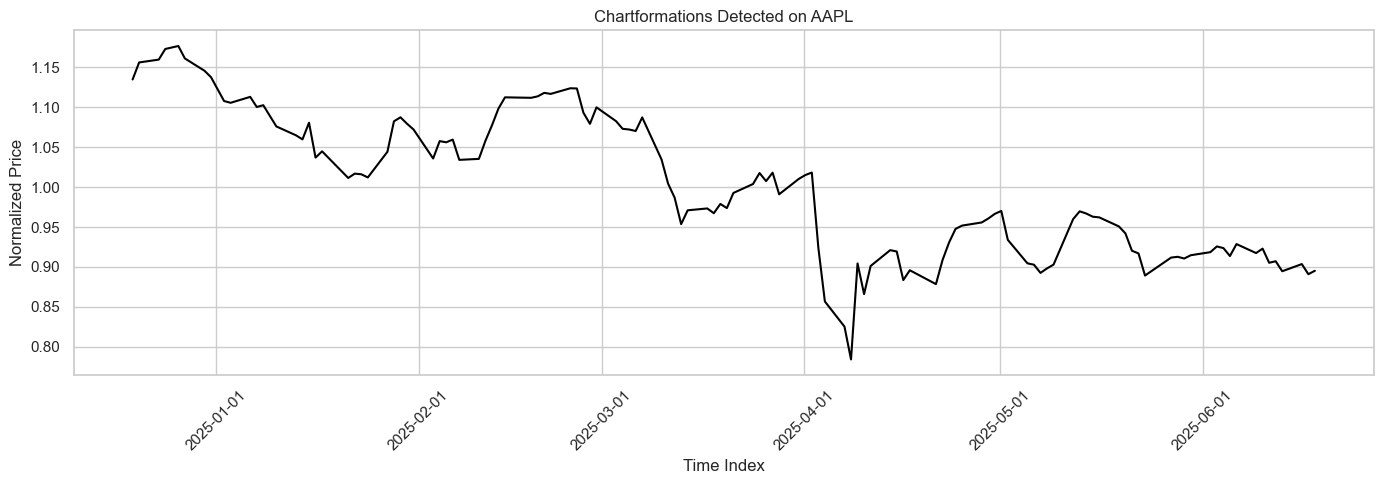

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


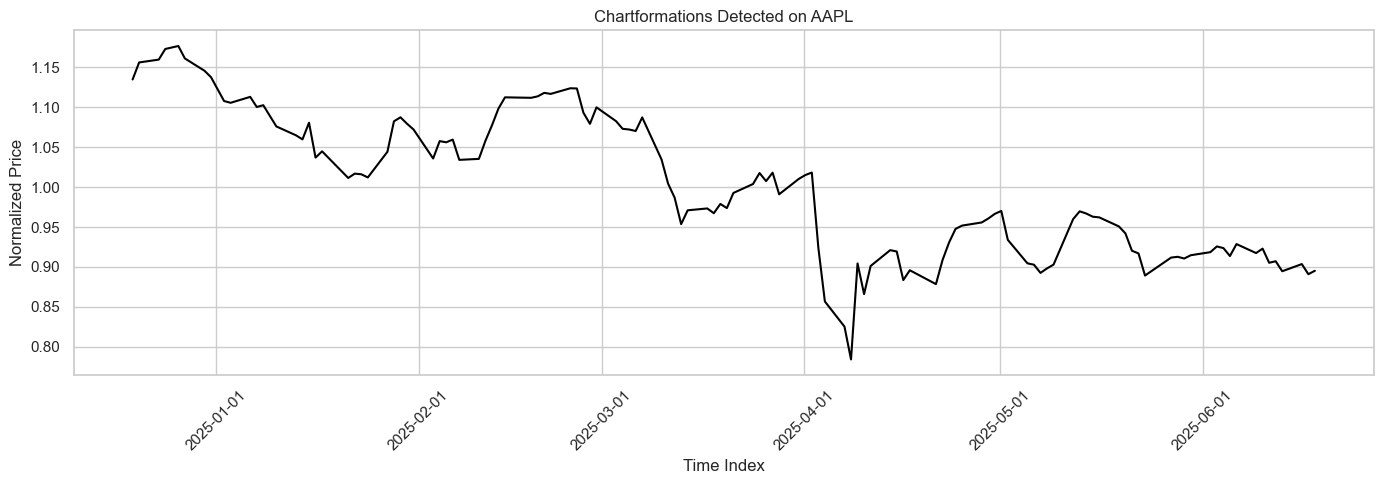

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


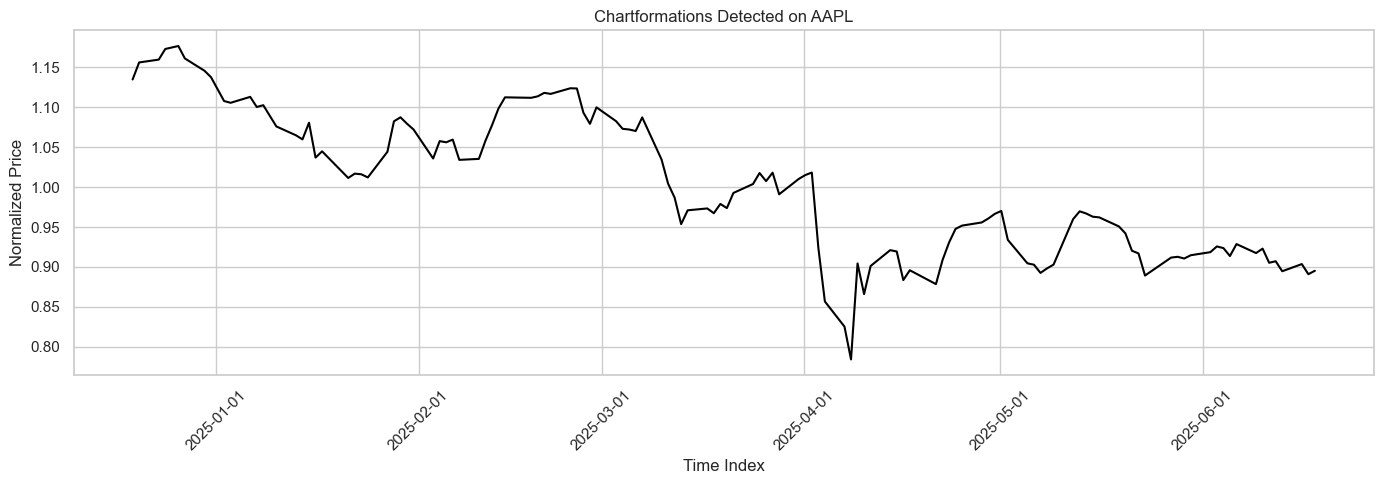

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 60 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_Flag - BearishPennant (0.74) | 2025-01-15 00:00:00-05:00 to 2025-04-17 00:00:00-04:00 | Conf: 0.74
→ Group_Flag - BearishPennant (0.72) | 2025-03-19 00:00:00-04:00 to 2025-06-18 00:00:00-04:00 | Conf: 0.72


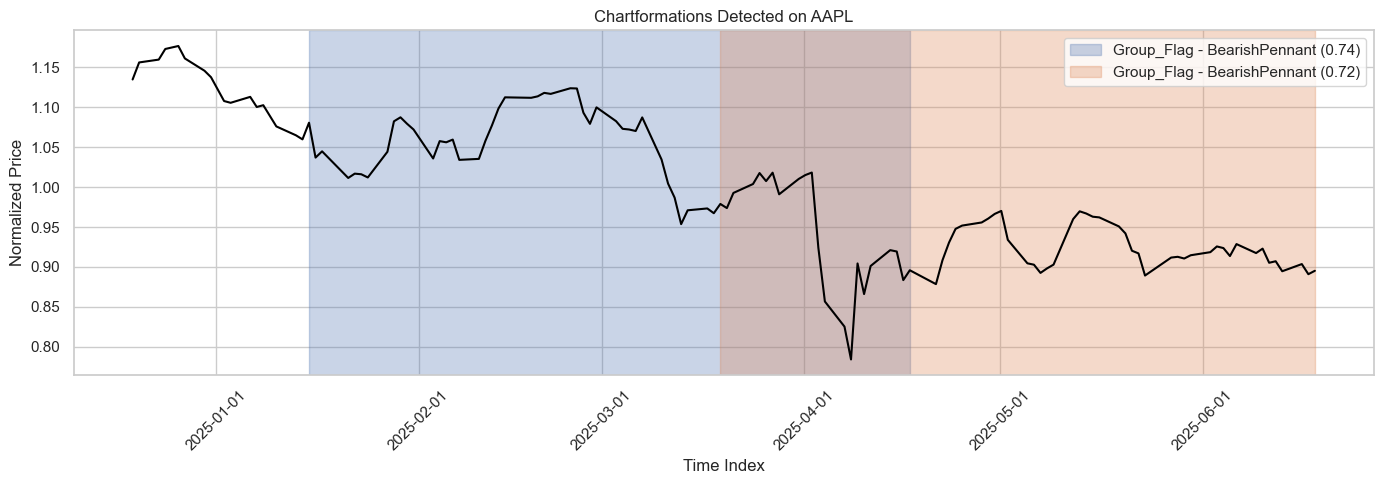

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 60 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_HeadShoulder - ReverseHeadAndShoulder (0.90) | 2024-12-20 00:00:00-05:00 to 2025-03-27 00:00:00-04:00 | Conf: 0.90
→ Group_HeadShoulder - ReverseHeadAndShoulder (0.89) | 2025-03-03 00:00:00-05:00 to 2025-06-03 00:00:00-04:00 | Conf: 0.89


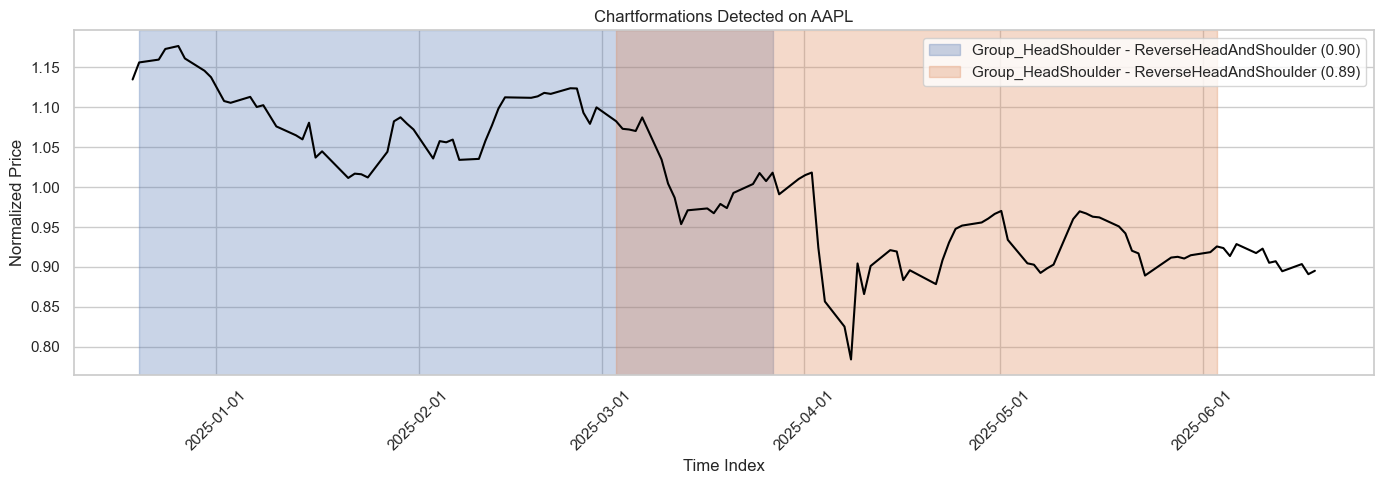

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


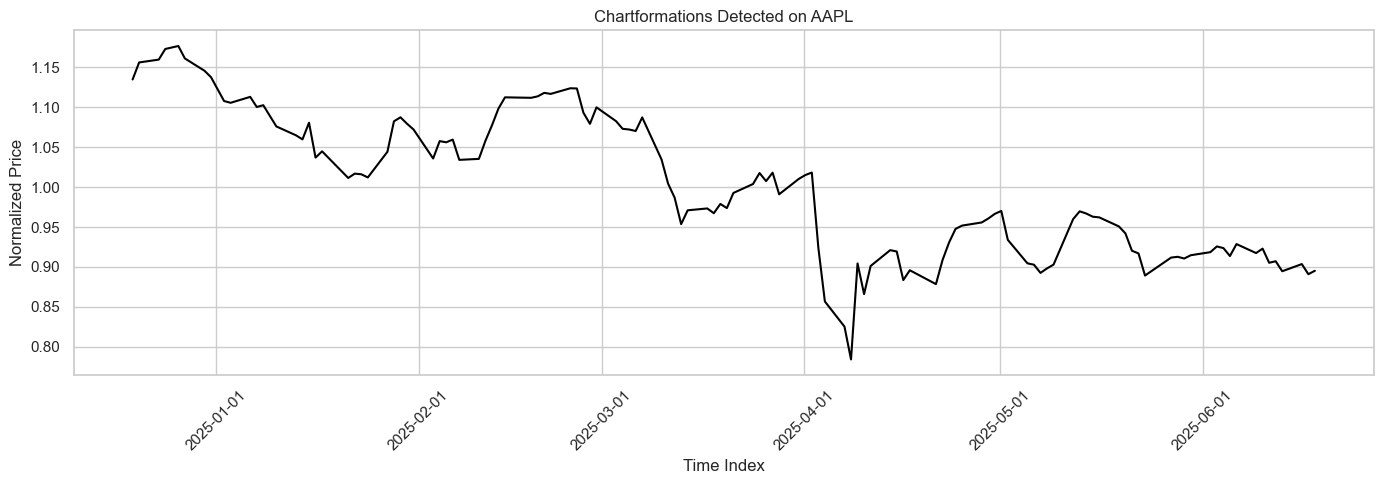

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


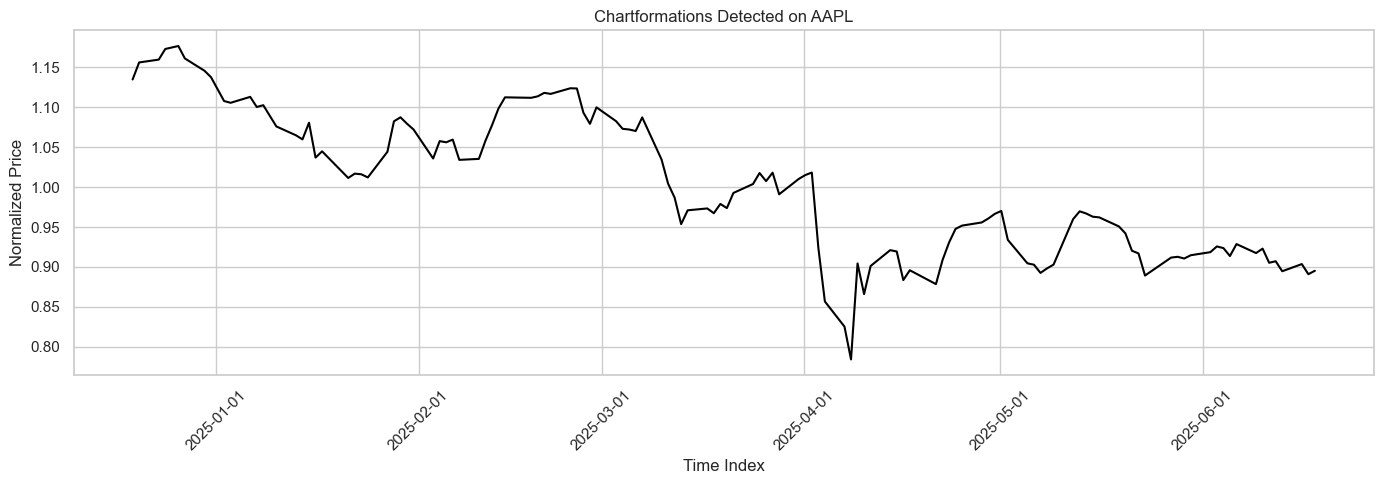

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


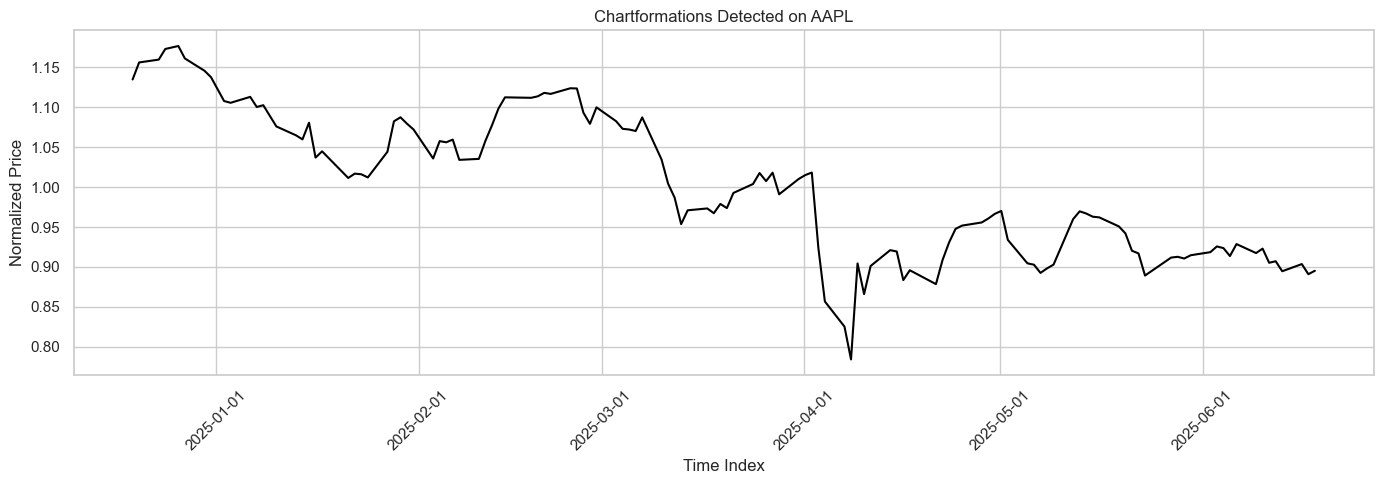

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 60 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_Triple - TripleBottom (0.69) | 2024-12-31 00:00:00-05:00 to 2025-04-04 00:00:00-04:00 | Conf: 0.69
→ Group_Triple - TripleBottom (0.68) | 2025-02-20 00:00:00-05:00 to 2025-05-22 00:00:00-04:00 | Conf: 0.68


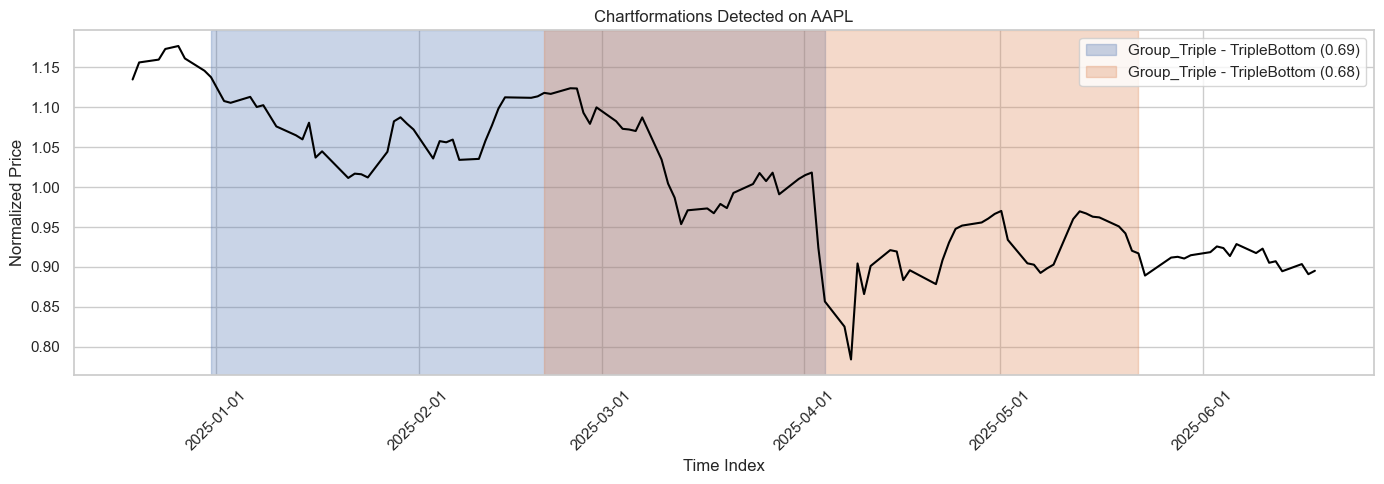

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


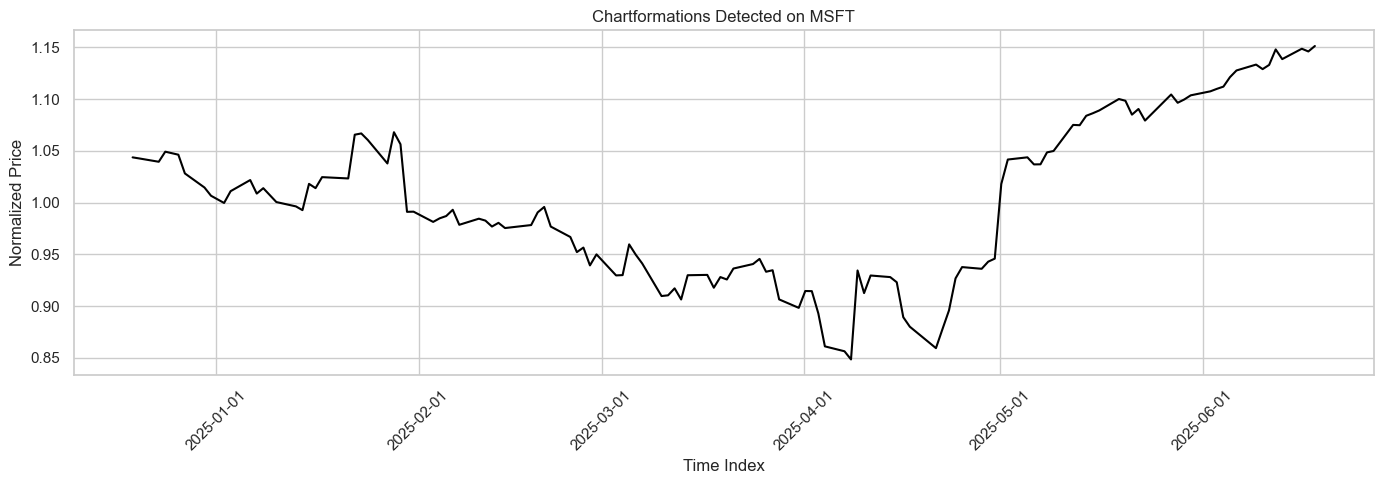

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


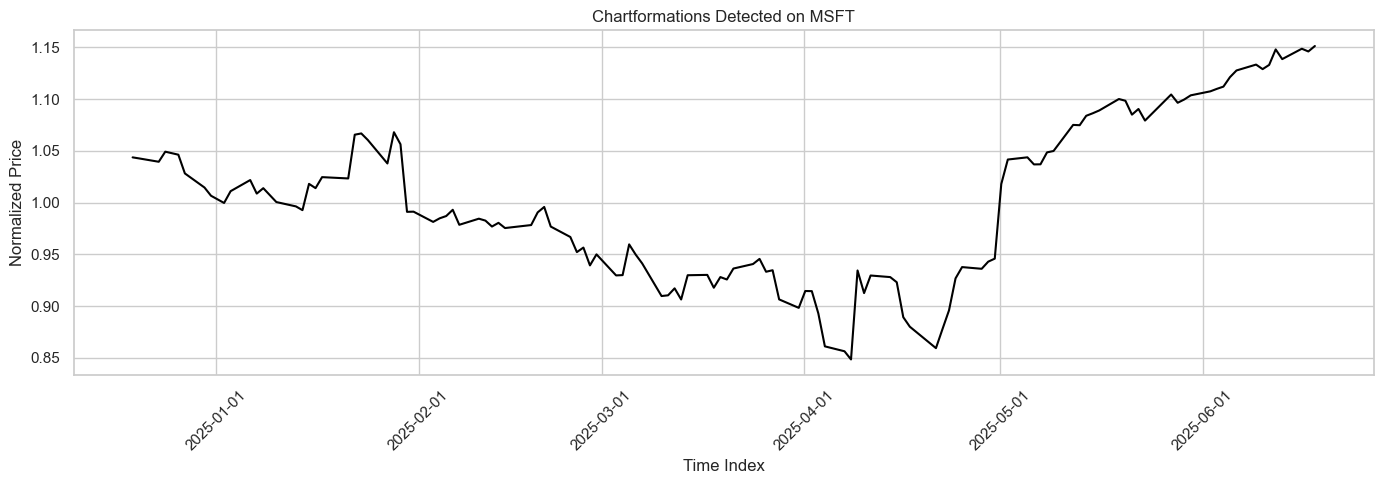

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


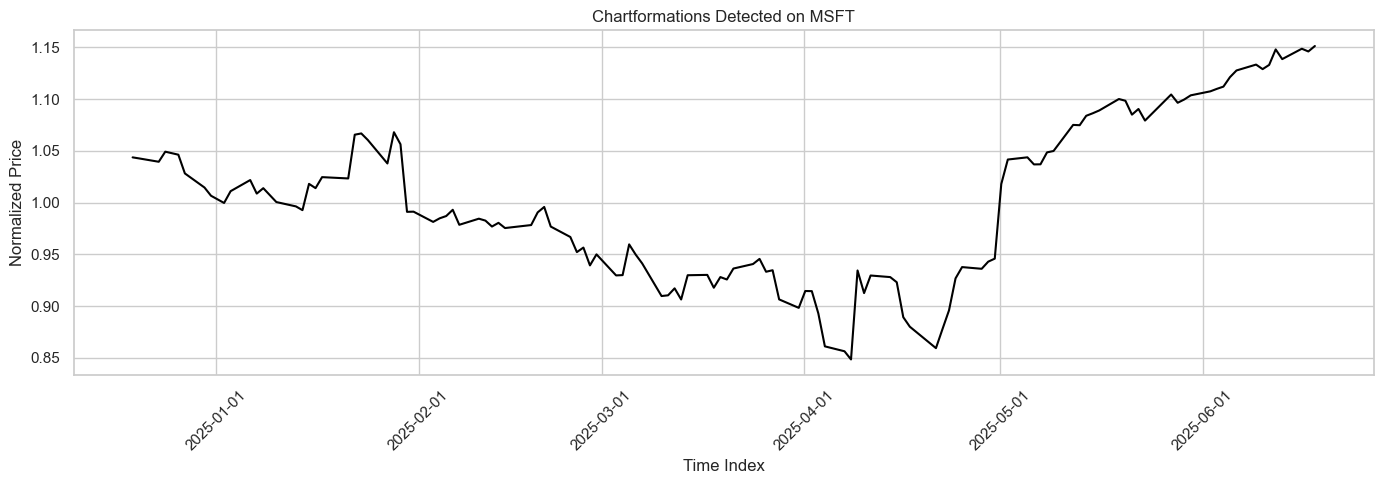

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 60 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_Flag - BearishPennant (0.72) | 2024-12-19 00:00:00-05:00 to 2025-03-26 00:00:00-04:00 | Conf: 0.72
→ Group_Flag - BearishPennant (0.70) | 2025-02-11 00:00:00-05:00 to 2025-05-14 00:00:00-04:00 | Conf: 0.70


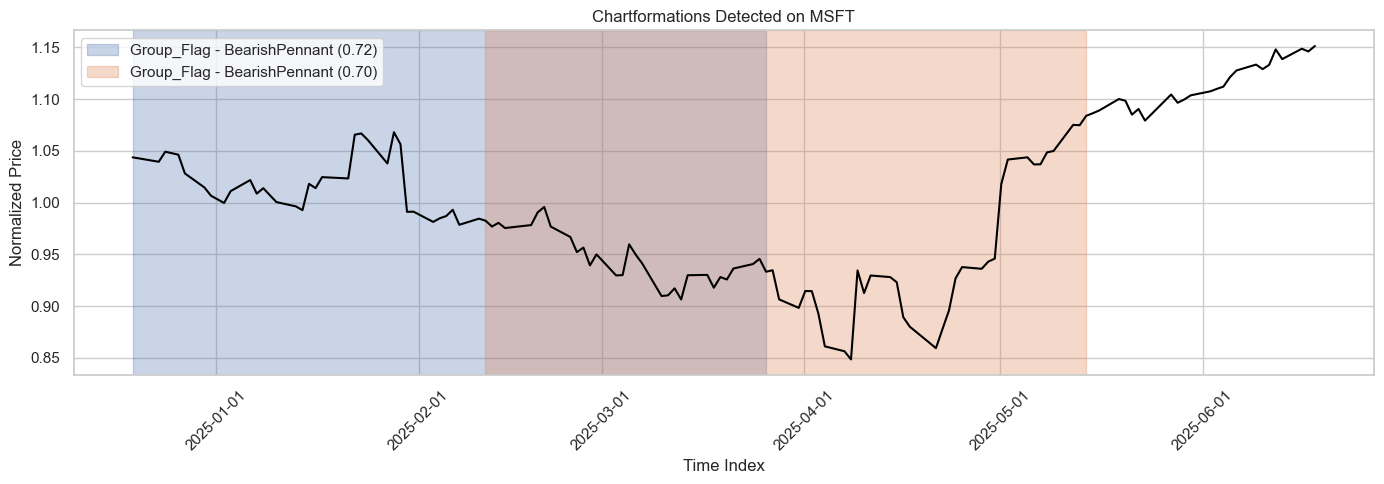

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 60 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_HeadShoulder - ReverseHeadAndShoulder (0.92) | 2025-03-19 00:00:00-04:00 to 2025-06-18 00:00:00-04:00 | Conf: 0.92
→ Group_HeadShoulder - ReverseHeadAndShoulder (0.89) | 2024-12-19 00:00:00-05:00 to 2025-03-26 00:00:00-04:00 | Conf: 0.89


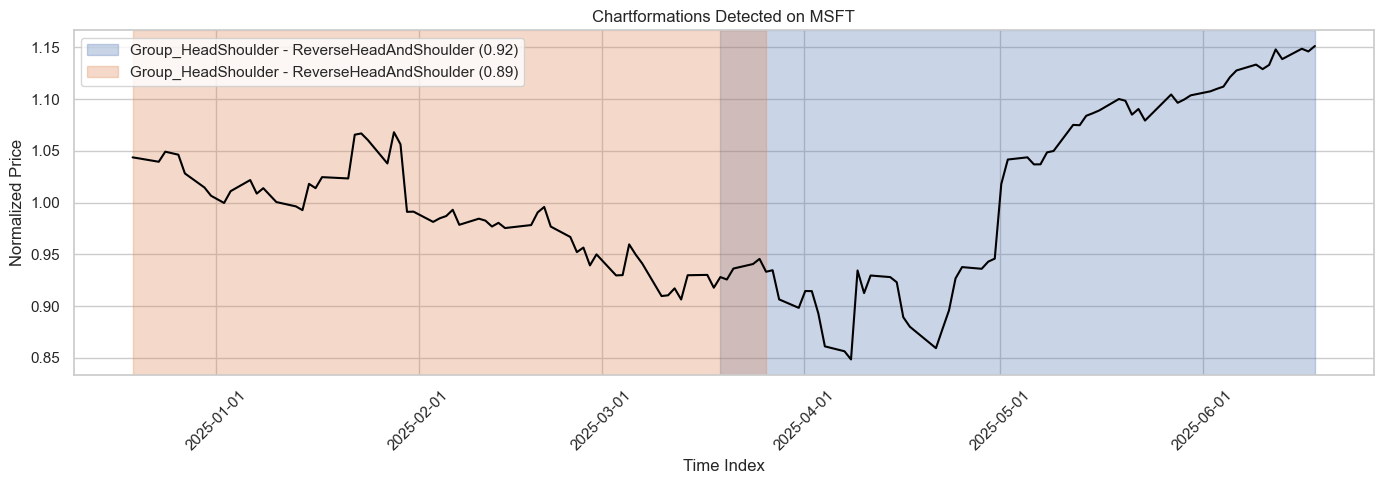

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


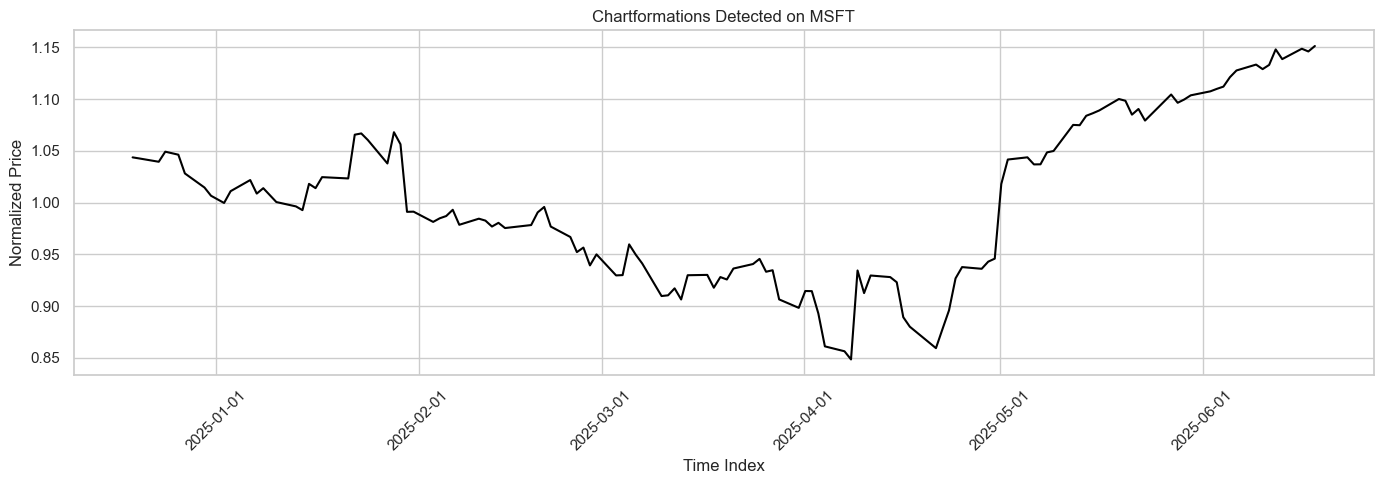

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


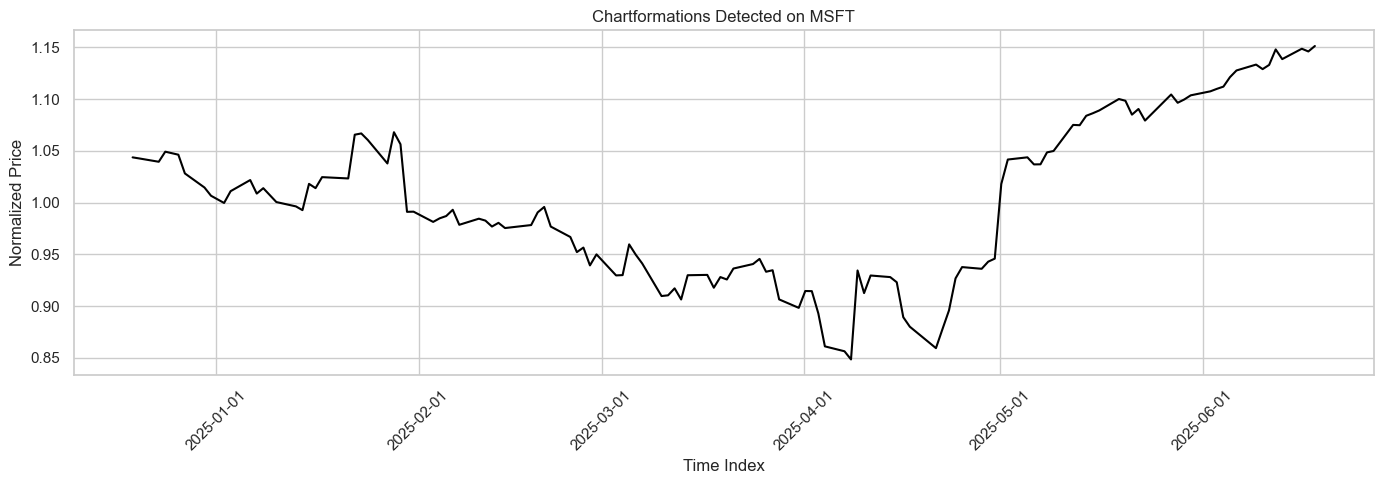

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


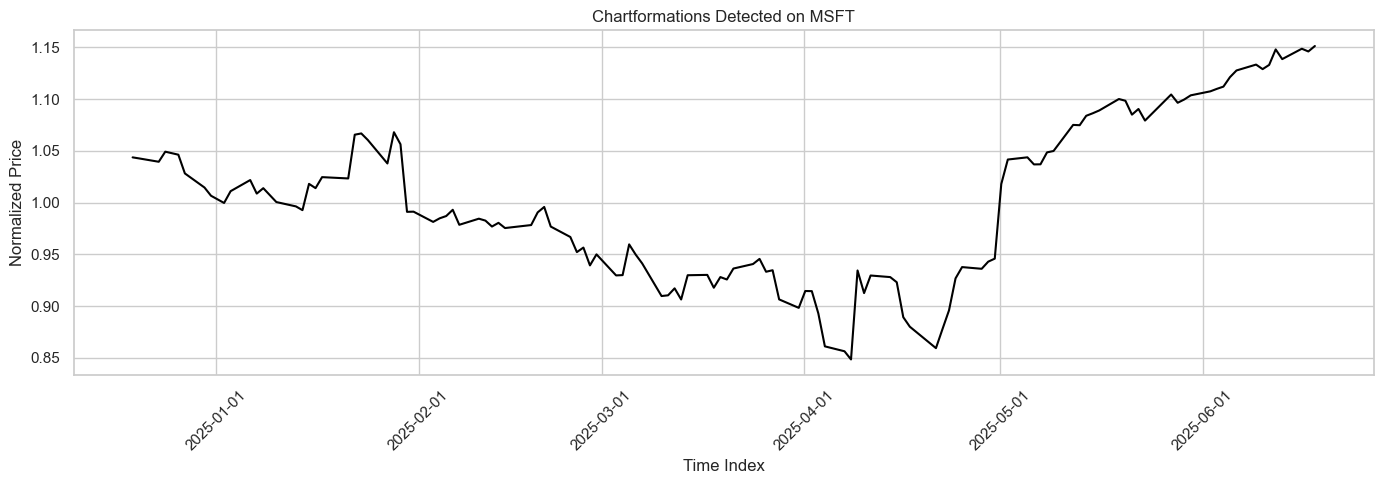

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 60 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_Triple - TripleBottom (0.70) | 2025-03-19 00:00:00-04:00 to 2025-06-18 00:00:00-04:00 | Conf: 0.70
→ Group_Triple - TripleBottom (0.68) | 2024-12-27 00:00:00-05:00 to 2025-04-02 00:00:00-04:00 | Conf: 0.68


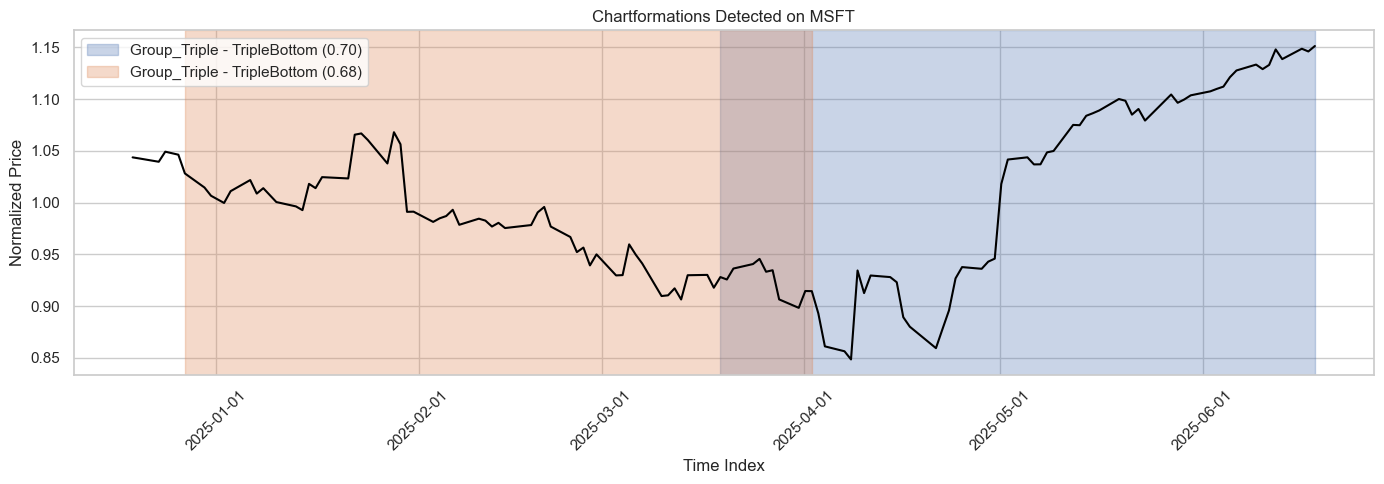

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


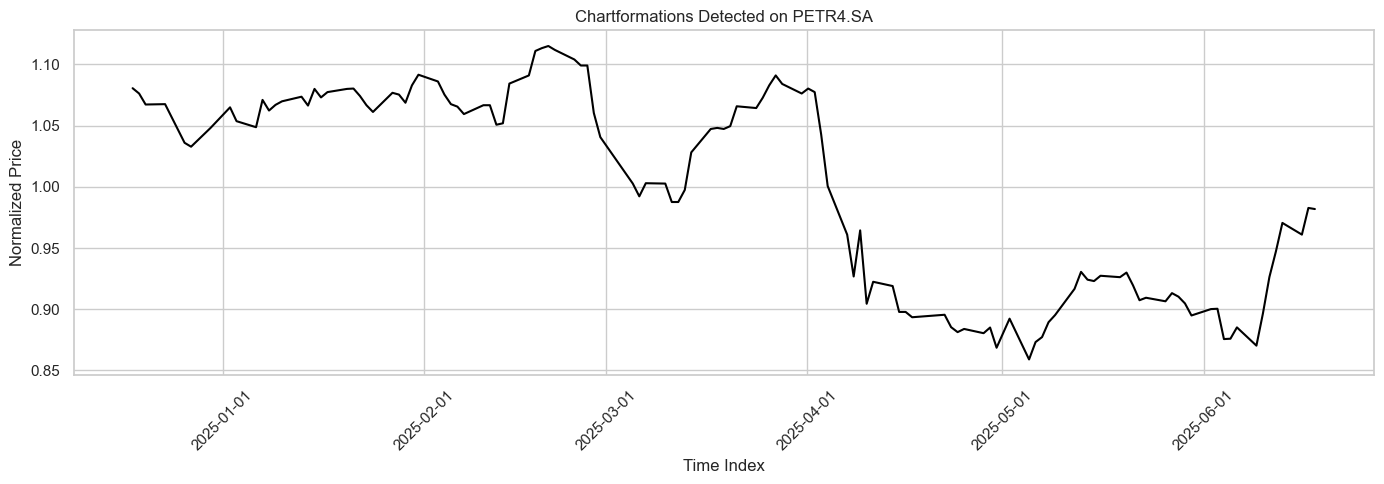

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


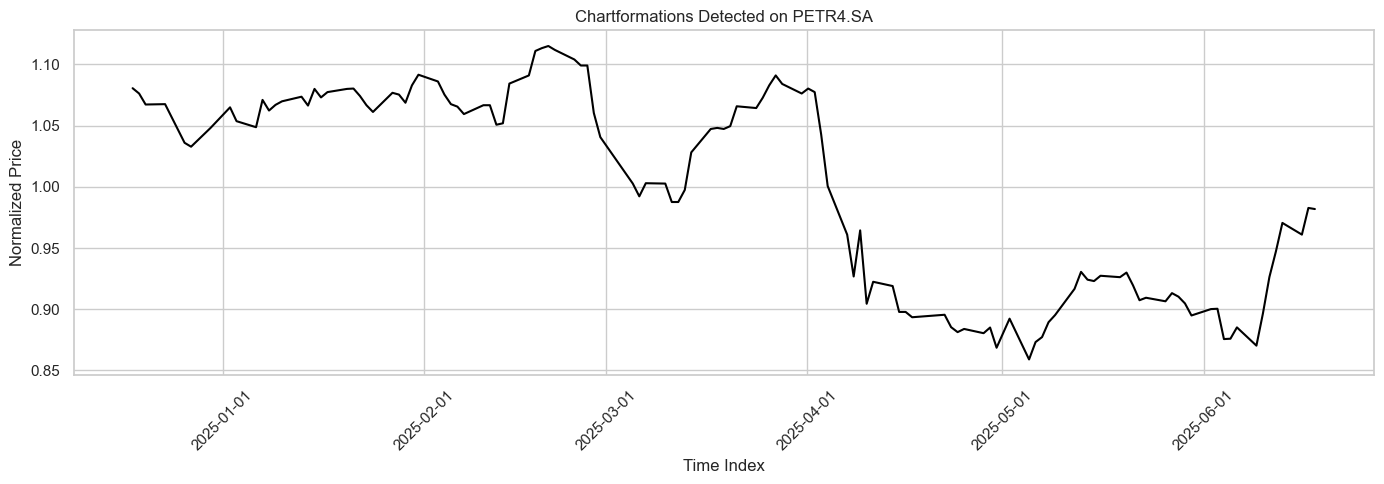

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


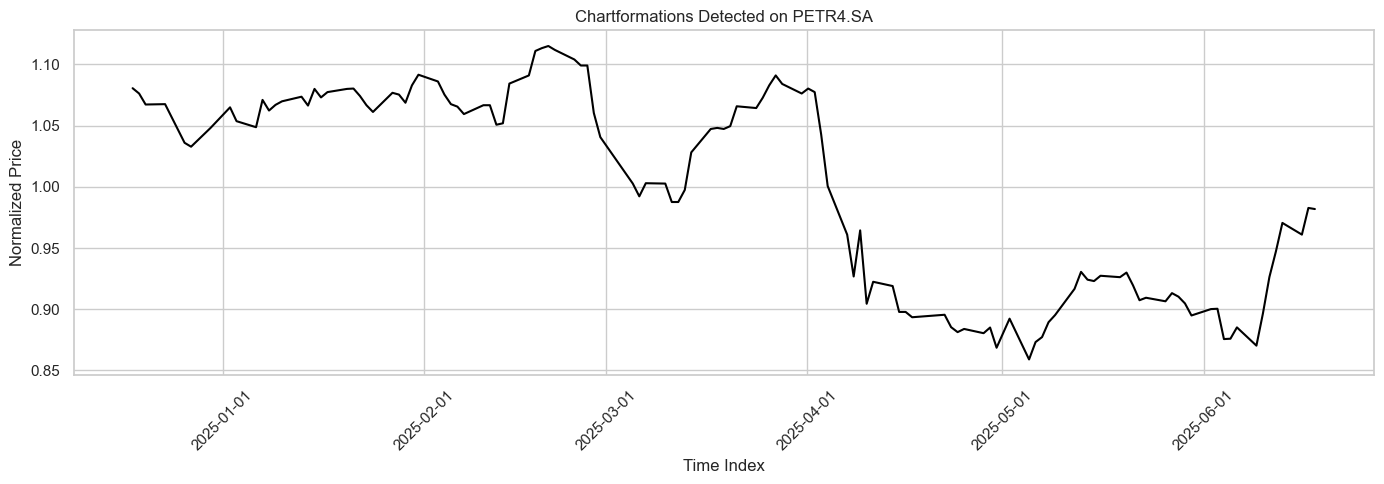

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 59 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_Flag - BearishPennant (0.73) | 2025-02-19 00:00:00-03:00 to 2025-05-27 00:00:00-03:00 | Conf: 0.73
→ Group_Flag - BearishPennant (0.71) | 2024-12-18 00:00:00-03:00 to 2025-03-26 00:00:00-03:00 | Conf: 0.71


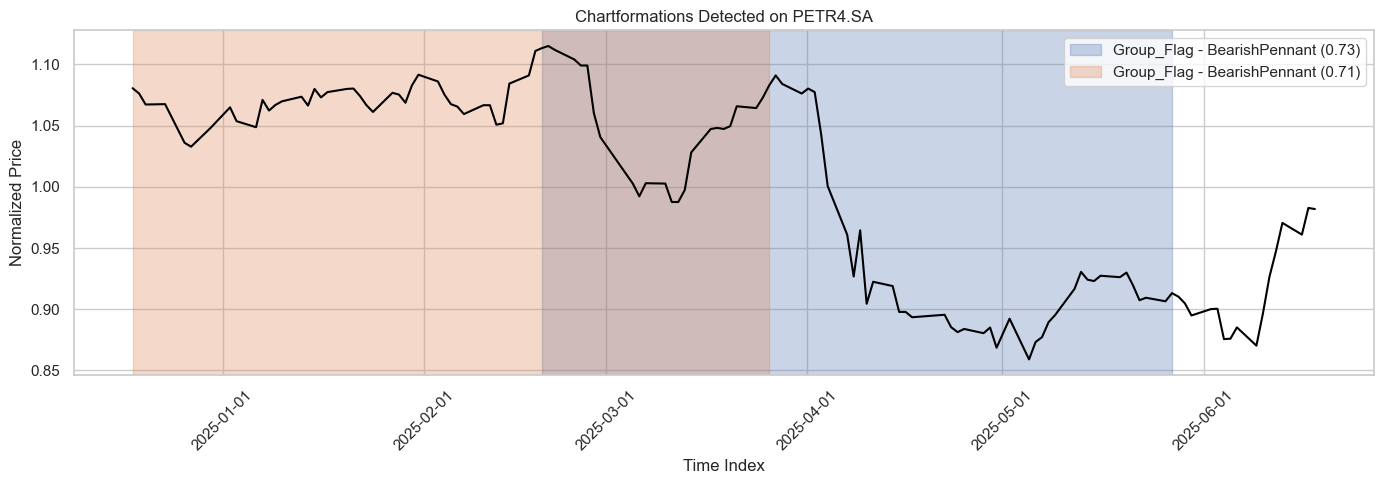

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 59 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_HeadShoulder - ReverseHeadAndShoulder (0.90) | 2024-12-18 00:00:00-03:00 to 2025-03-26 00:00:00-03:00 | Conf: 0.90
→ Group_HeadShoulder - ReverseHeadAndShoulder (0.88) | 2025-03-13 00:00:00-03:00 to 2025-06-16 00:00:00-03:00 | Conf: 0.88


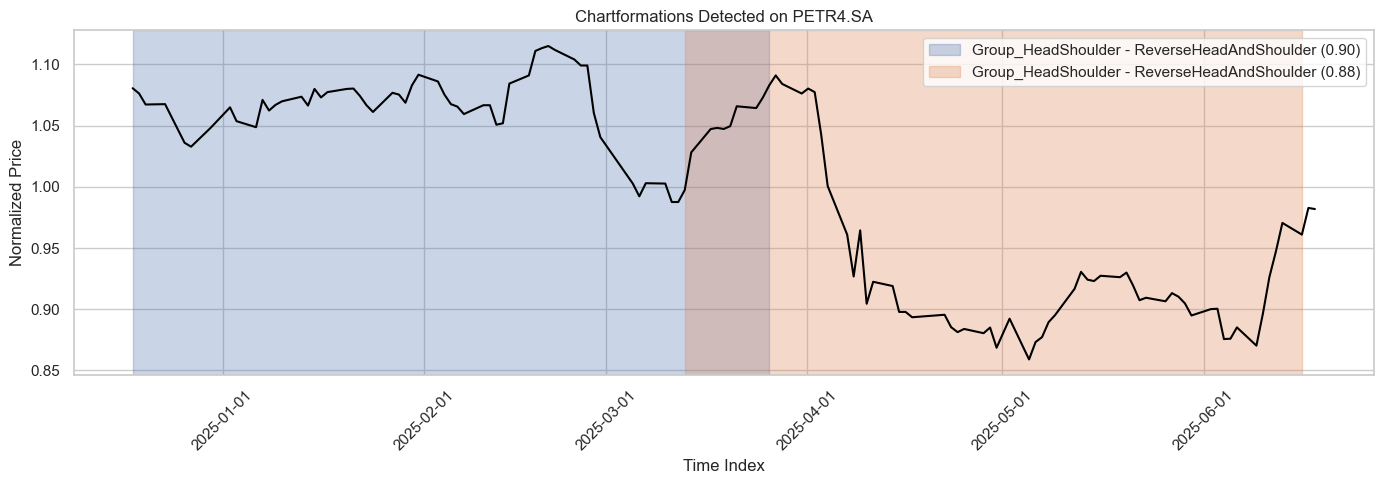

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


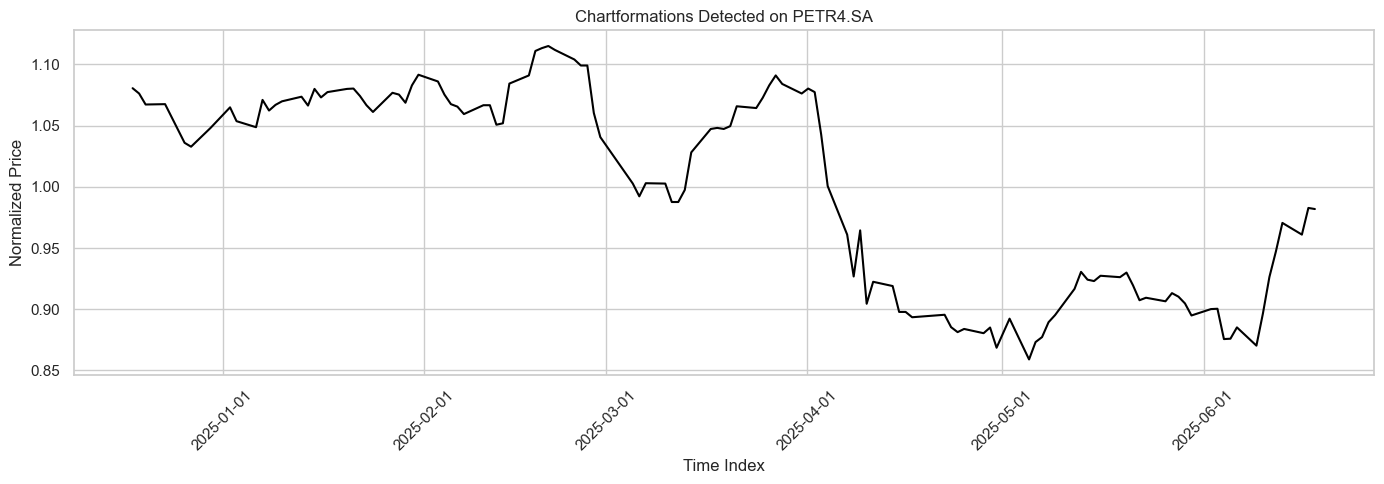

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


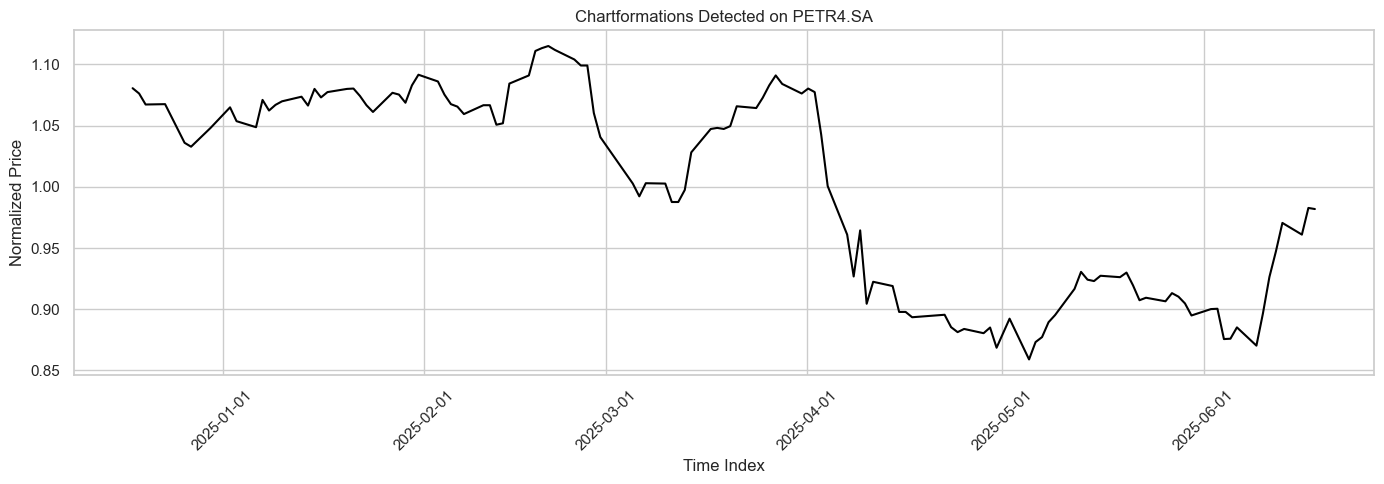

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


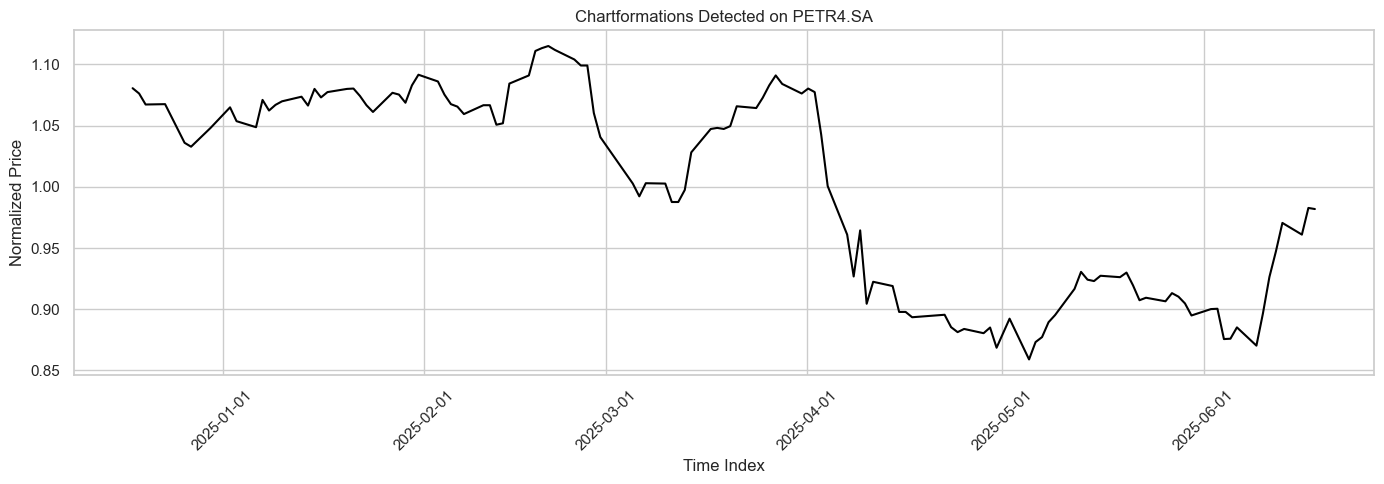

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 59 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_Triple - TripleBottom (0.70) | 2024-12-30 00:00:00-03:00 to 2025-04-03 00:00:00-03:00 | Conf: 0.70
→ Group_Triple - TripleBottom (0.68) | 2025-03-18 00:00:00-03:00 to 2025-06-18 00:00:00-03:00 | Conf: 0.68


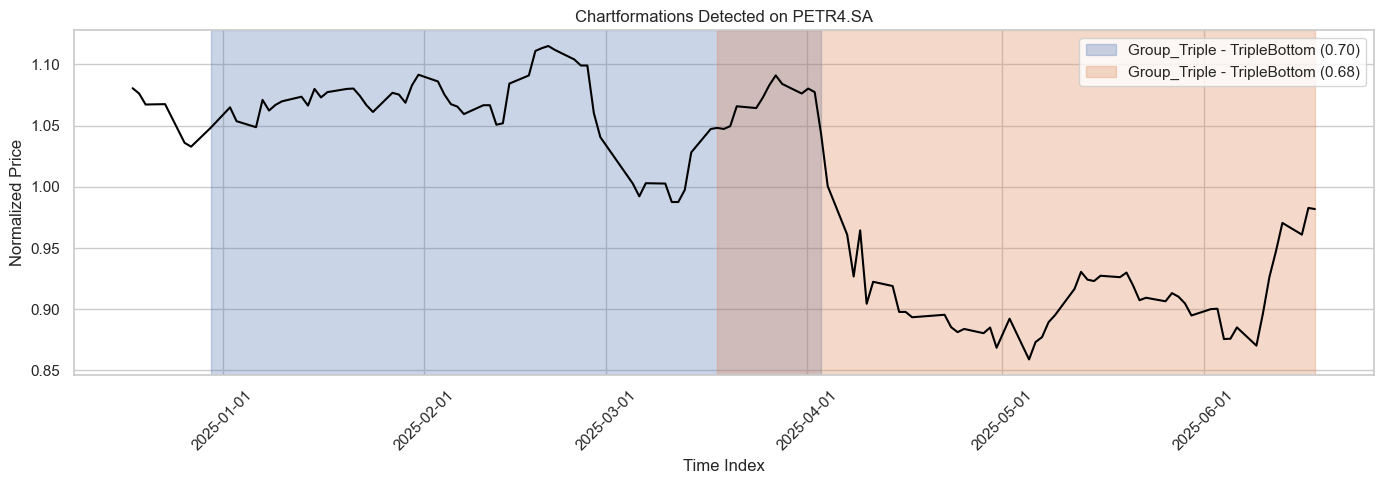

[INFO] Loading data for: VALE3.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


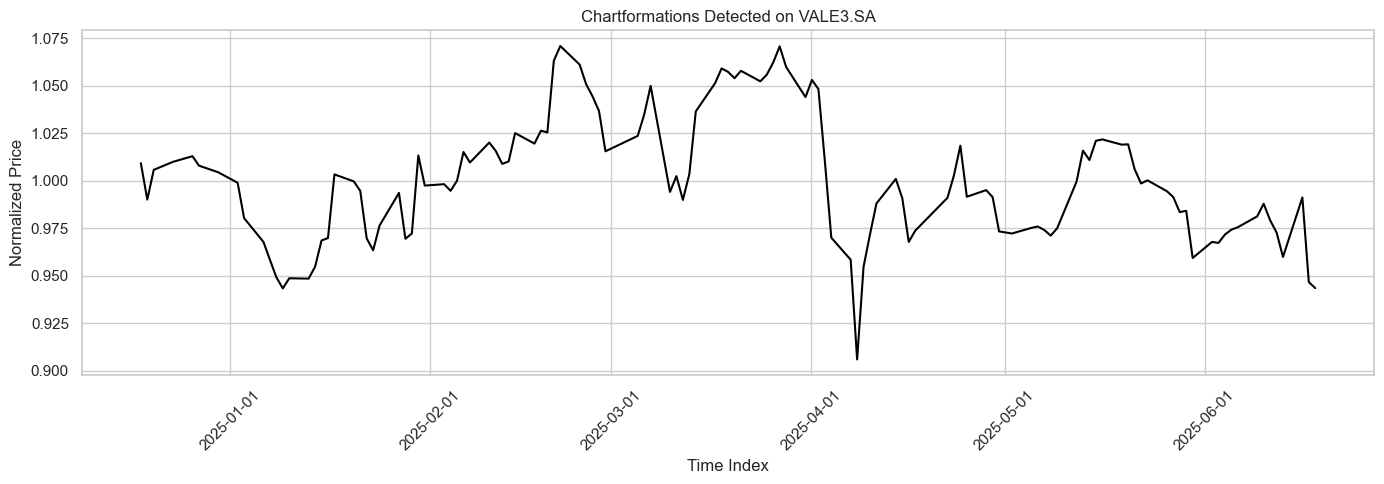

[INFO] Loading data for: VALE3.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


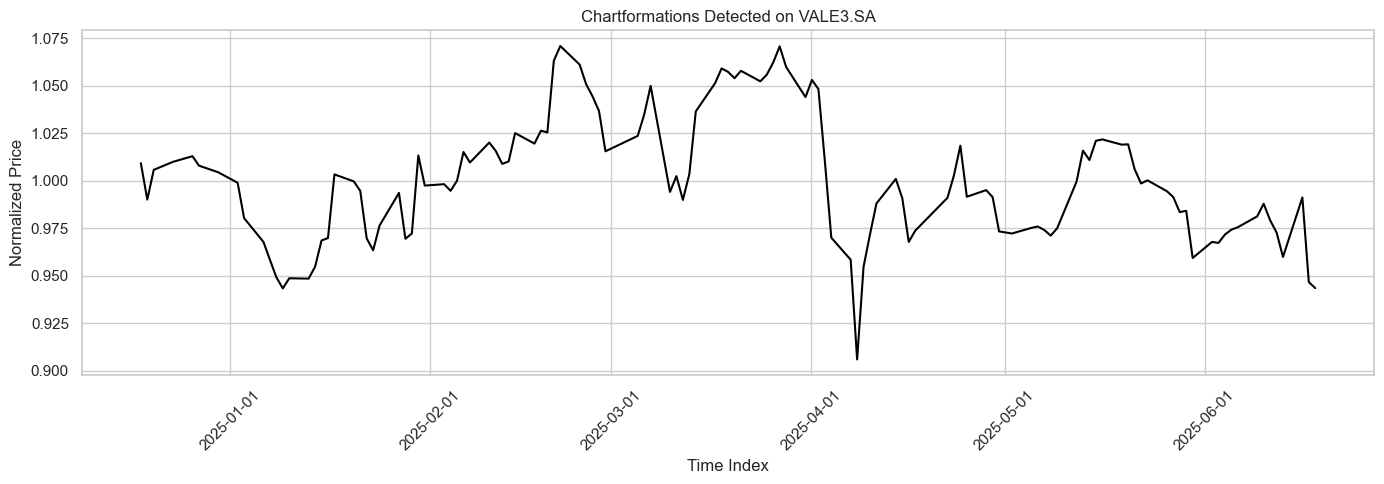

[INFO] Loading data for: VALE3.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


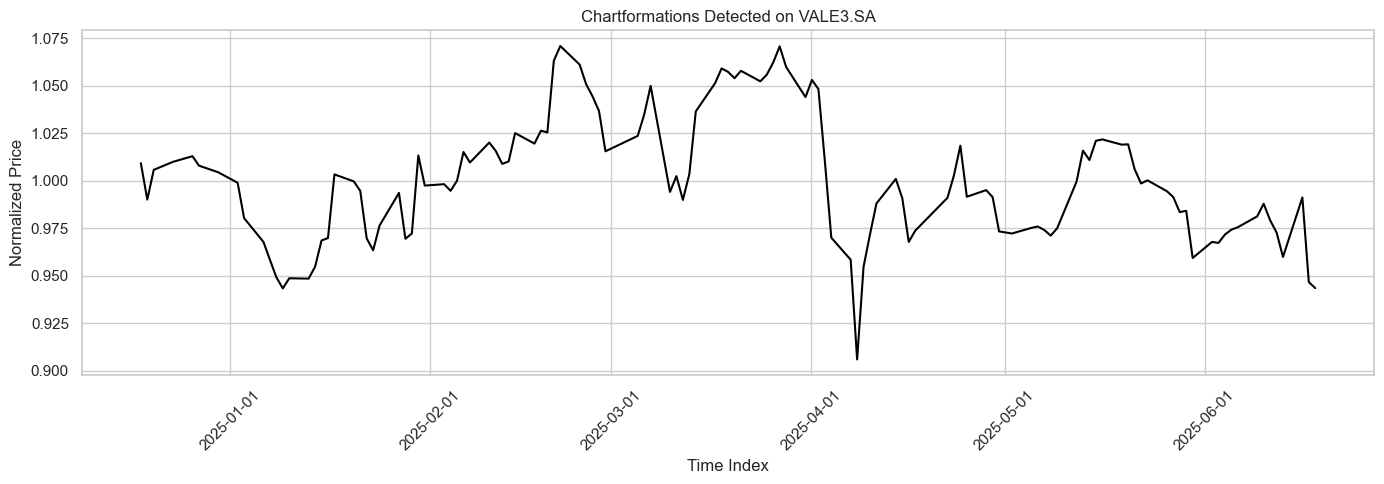

[INFO] Loading data for: VALE3.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 59 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_Flag - BearishPennant (0.73) | 2025-01-15 00:00:00-03:00 to 2025-04-17 00:00:00-03:00 | Conf: 0.73
→ Group_Flag - BearishPennant (0.71) | 2025-03-17 00:00:00-03:00 to 2025-06-18 00:00:00-03:00 | Conf: 0.71


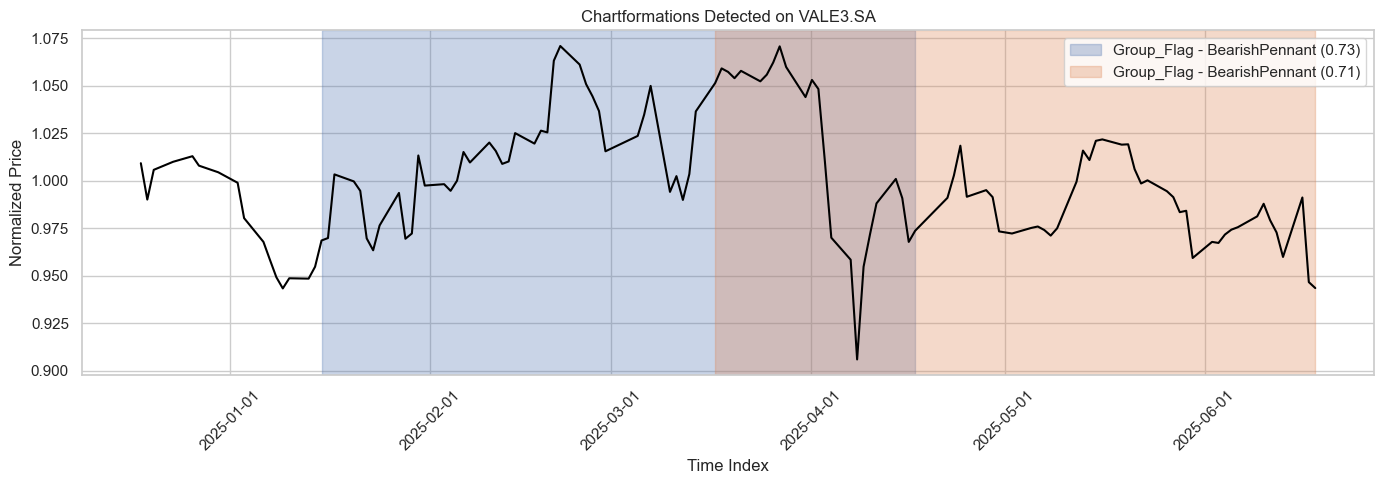

[INFO] Loading data for: VALE3.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 59 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_HeadShoulder - ReverseHeadAndShoulder (0.91) | 2024-12-20 00:00:00-03:00 to 2025-03-28 00:00:00-03:00 | Conf: 0.91
→ Group_HeadShoulder - ReverseHeadAndShoulder (0.90) | 2025-02-21 00:00:00-03:00 to 2025-05-29 00:00:00-03:00 | Conf: 0.90


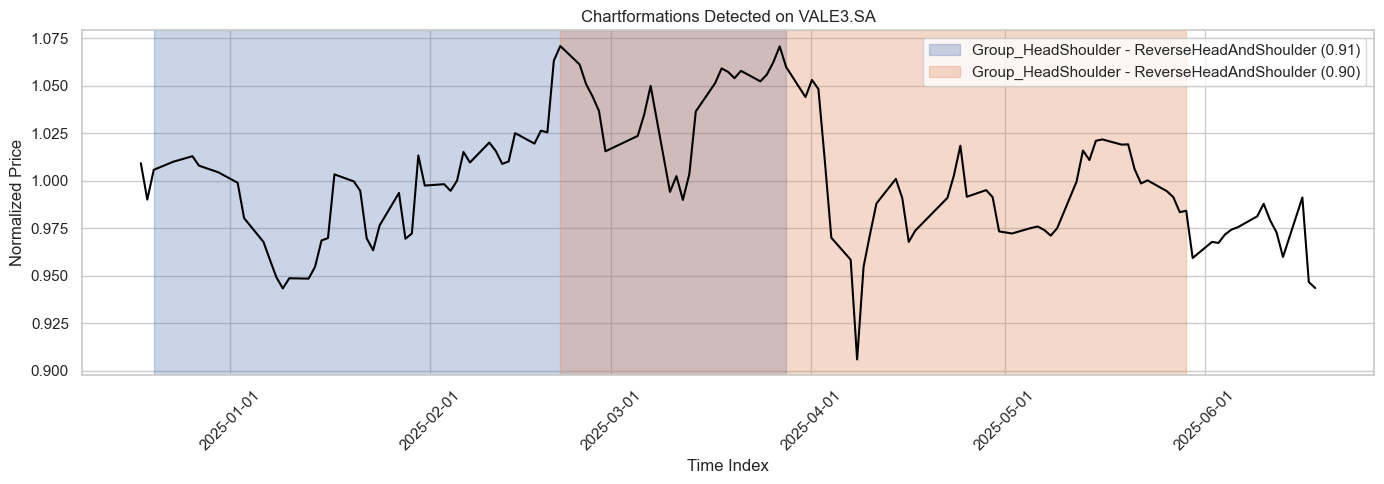

[INFO] Loading data for: VALE3.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


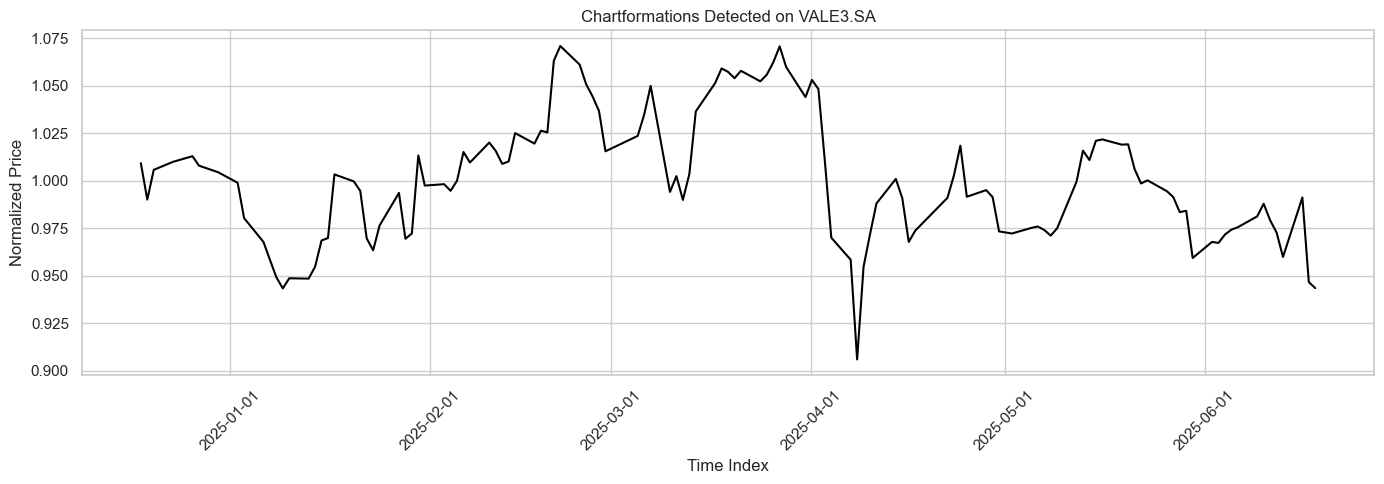

[INFO] Loading data for: VALE3.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


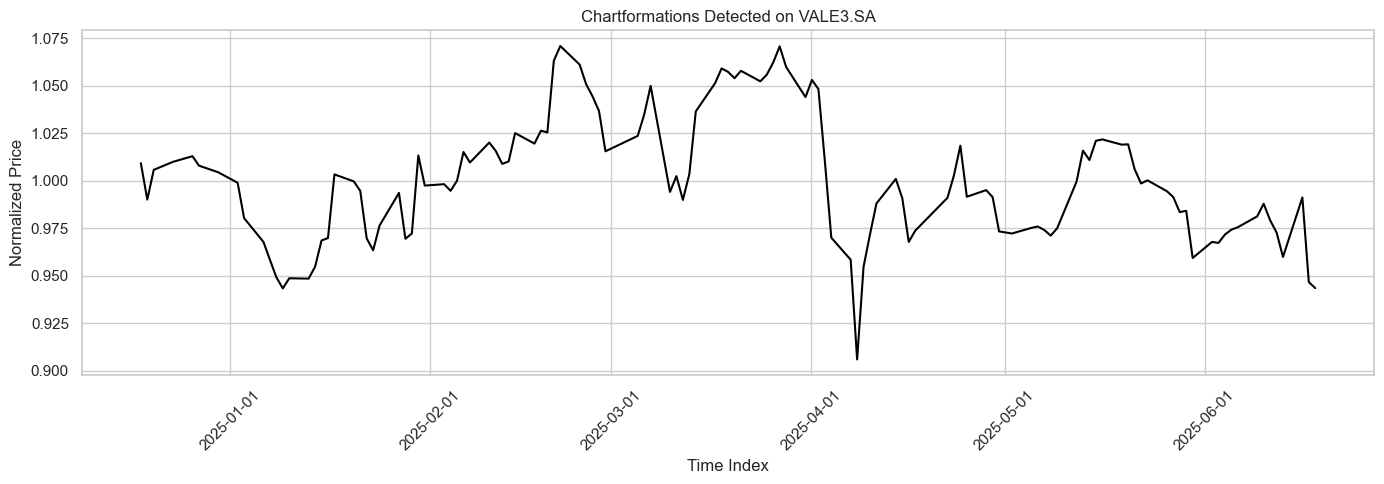

[INFO] Loading data for: VALE3.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


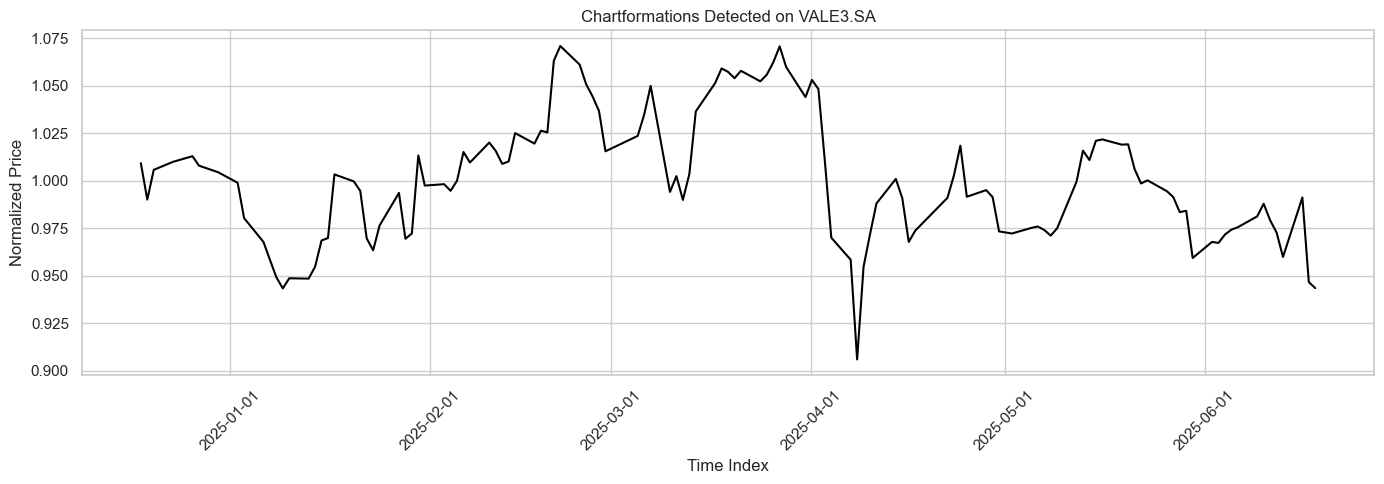

[INFO] Loading data for: VALE3.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 59 raw boxes, applying NMS...
[INFO] Final detections: 2
→ Group_Triple - TripleBottom (0.70) | 2024-12-27 00:00:00-03:00 to 2025-04-02 00:00:00-03:00 | Conf: 0.70
→ Group_Triple - TripleBottom (0.69) | 2025-02-20 00:00:00-03:00 to 2025-05-28 00:00:00-03:00 | Conf: 0.69


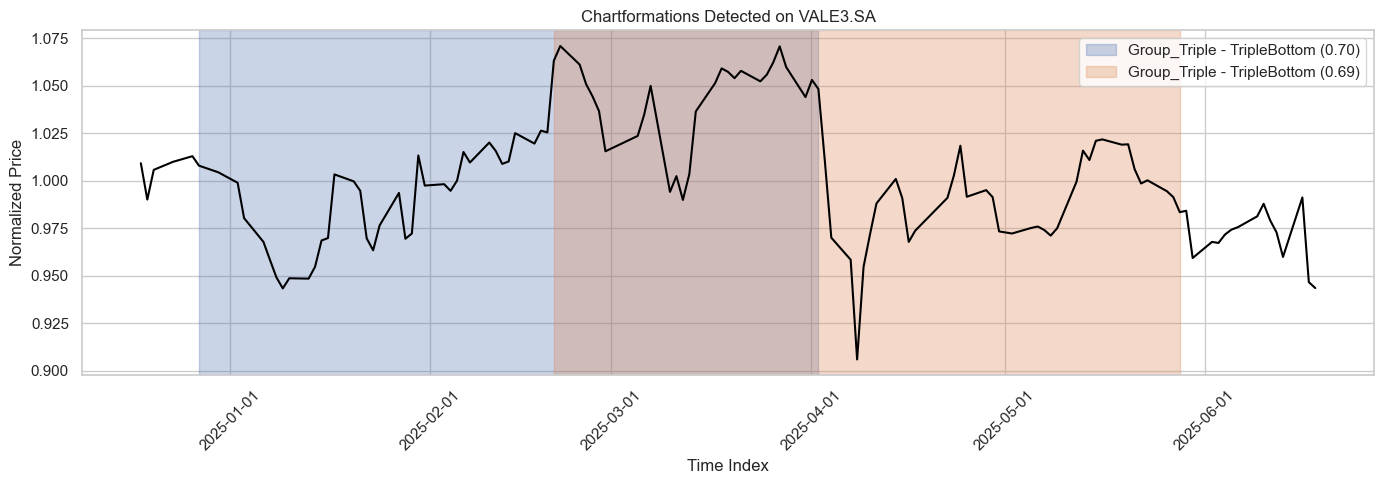

In [ ]:
tickers = ["AAPL", "MSFT", "PETR4.SA", "VALE3.SA"]
for t in tickers:
    myutils.detect_all_groups_on_ticker(t,
                                        model_folder="aaatemp/groups4cnn",
                                        window_size=64, # depending on the model training, here 64 is used!
                                        threshold=0.60)

# CNN 2D

* CNN 1D --> use data .npy!!!... need padding to set the size of array (Cons). Pros: quick, less memmory, use temporal series direct.

* CNN 2D --> use data .png!!!... don´t need padding (Pros!), because the plots (figure) are built with standart size and resolution.

# APPLICATION --> yahoo data

## data

In [53]:
aapl_ticker = yf.Ticker("AAPL")
aapl_hist = aapl_ticker.history(period="6mo", interval="1d")  # ou "60d", "1h", etc.

In [54]:
appl_series = aapl_hist["Close"].values.astype(np.float32)
appl_series_normalized = appl_series / np.mean(appl_series) # normalization. mean = the same method used in the dataset!

print(appl_series.shape)
print(aapl_hist.shape)
print(aapl_hist.head())

(123,)
(123, 7)
                                 Open        High         Low       Close  \
Date                                                                        
2024-12-19 00:00:00-05:00  246.904406  251.393577  246.495389  249.188889   
2024-12-20 00:00:00-05:00  247.443103  254.386361  245.098768  253.877594   
2024-12-23 00:00:00-05:00  254.156919  255.034791  252.840088  254.655716   
2024-12-24 00:00:00-05:00  254.875189  257.588630  254.675658  257.578674   
2024-12-26 00:00:00-05:00  257.568678  259.474086  257.010028  258.396667   

                              Volume  Dividends  Stock Splits  
Date                                                           
2024-12-19 00:00:00-05:00   60882300        0.0           0.0  
2024-12-20 00:00:00-05:00  147495300        0.0           0.0  
2024-12-23 00:00:00-05:00   40858800        0.0           0.0  
2024-12-24 00:00:00-05:00   23234700        0.0           0.0  
2024-12-26 00:00:00-05:00   27237100        0.0           0.

In [56]:
model_cnn1d_v1_from_file = load_model(model_cnn1d_v1_file)  # Load the model from file


X_windows, indices = myutils.sliding_windows(appl_series_normalized, window_size=64, stride=1)
X_windows = np.expand_dims(X_windows, axis=-1)  # required for CNN 1D

pred_probs = model.predict(X_windows)
pred_classes = np.argmax(pred_probs, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [57]:
threshold = 0.85
boxes = []
for i, prob in enumerate(pred_probs):
    class_id = np.argmax(prob)
    confidence = prob[class_id]
    if confidence >= threshold:
        boxes.append({
            "start": indices[i][0],
            "end": indices[i][1],
            "class": class_id,
            "confidence": confidence
        })


C:\Users\carlo\AppData\Local\Temp\ipykernel_12920\589224541.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


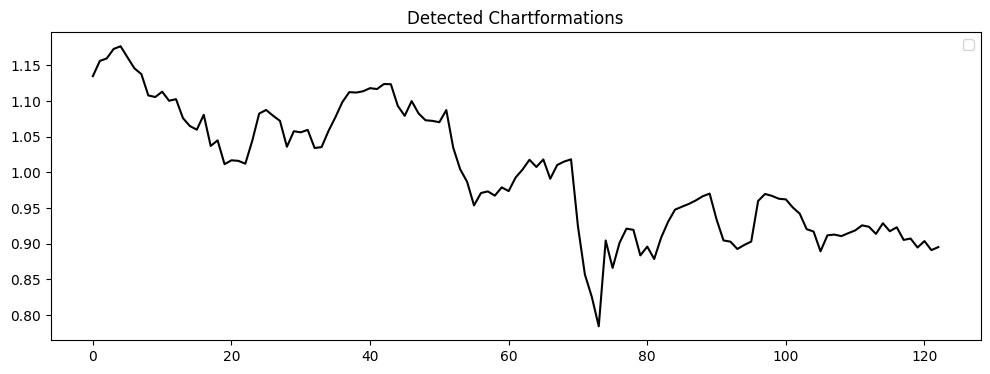

In [58]:
plt.figure(figsize=(12, 4))
plt.plot(appl_series_normalized, color='black')

for box in boxes:
    plt.axvspan(box["start"], box["end"], alpha=0.3, label=f'Class {box["class"]} ({box["confidence"]:.2f})')

plt.title("Detected Chartformations")
plt.legend()
plt.show()


# YAHOO TESTS

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


d:\dhbw_s3\wds23s4_fibu_chartformation\utils.py:729: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


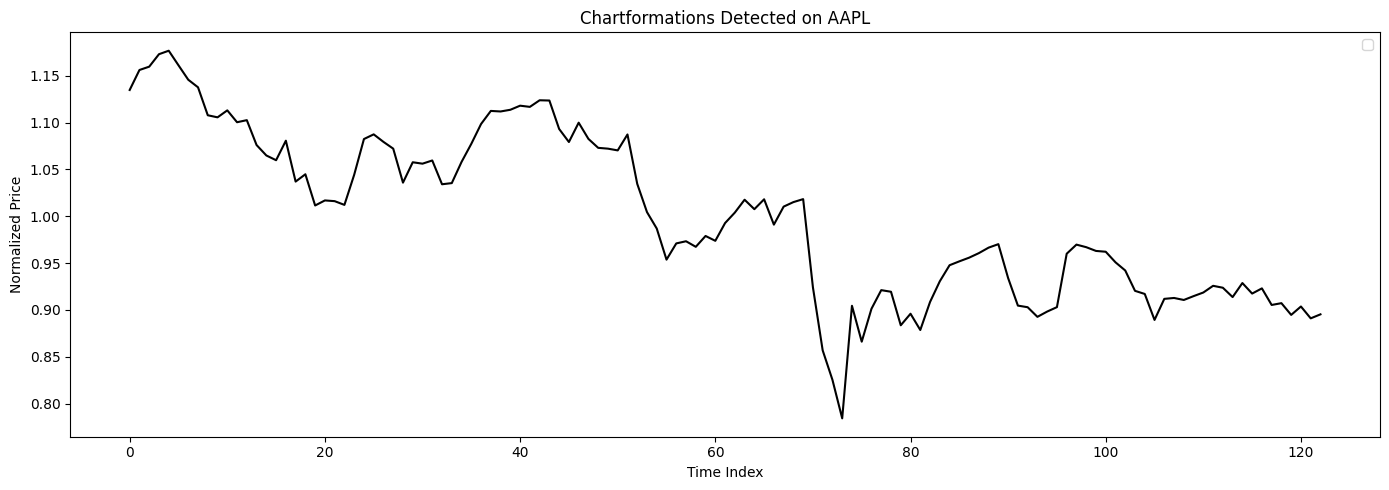

In [69]:
myutils.detect_patterns_on_ticker("AAPL", window_size=64, threshold=0.9, model_path=model_cnn1d_v1_file)  

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 0 raw boxes, applying NMS...
[INFO] Final detections: 0


d:\dhbw_s3\wds23s4_fibu_chartformation\utils.py:729: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


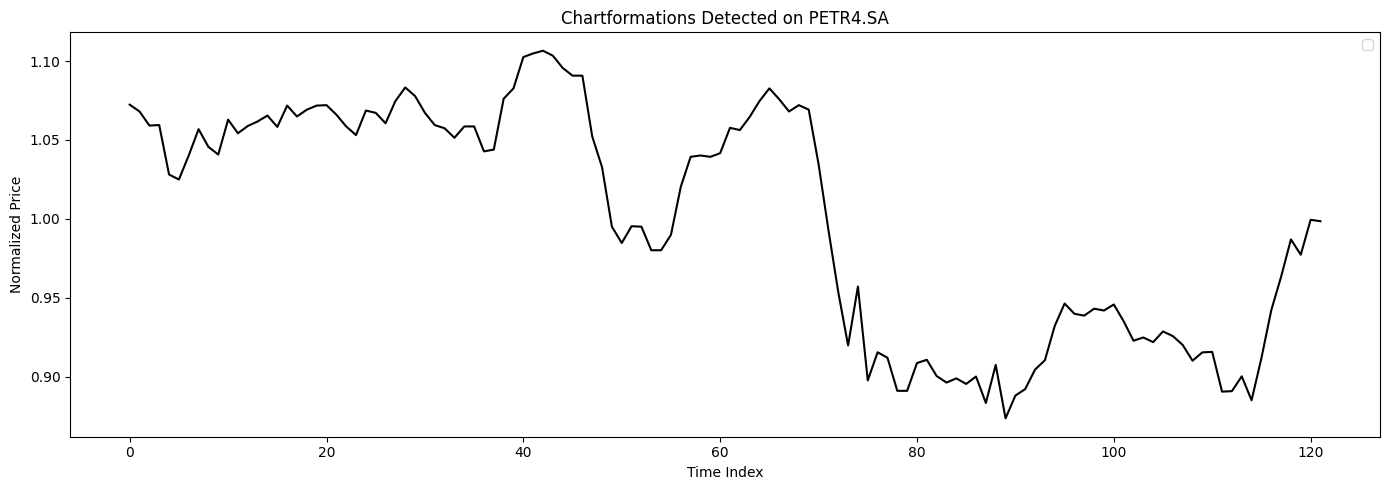

In [70]:
myutils.detect_patterns_on_ticker("PETR4.SA", window_size=64, threshold=0.9, model_path=model_cnn1d_v1_file)  

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...
[INFO] Found 2 raw boxes, applying NMS...
[INFO] Final detections: 1
→ Class 1 | 2025-03-19 00:00:00-04:00 to 2025-06-18 00:00:00-04:00 | Conf: 0.92


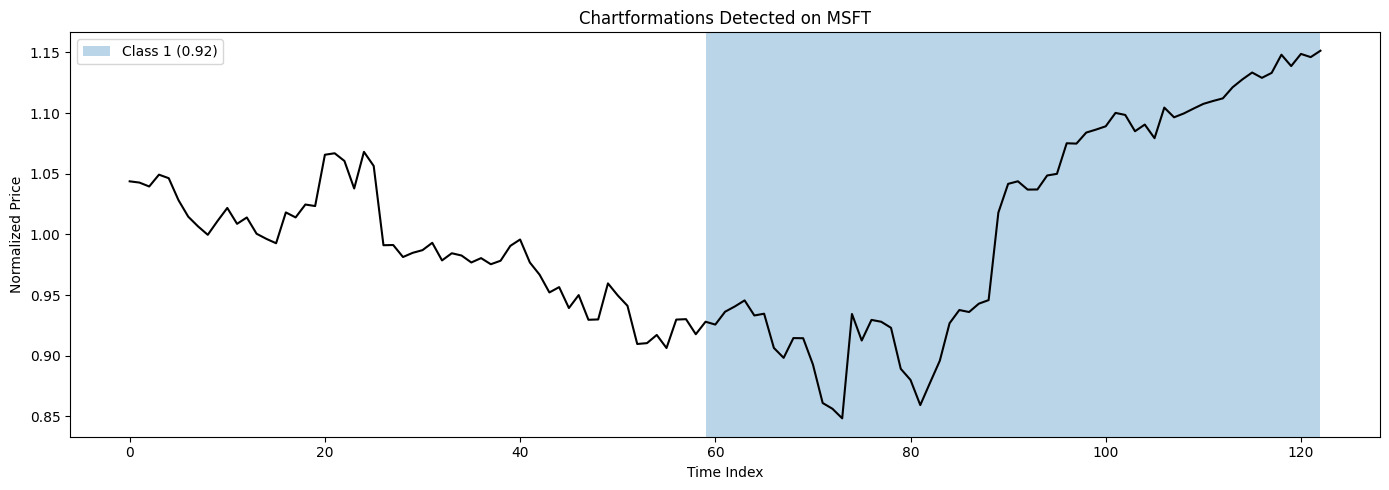

In [73]:
myutils.detect_patterns_on_ticker("MSFT", window_size=64, threshold=0.9, model_path=model_cnn1d_v1_file)  

